The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


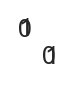

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# checks with data

In [6]:
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')

In [7]:
# This is the swapped dataset
b = pd.read_csv('../data/NetTCR/nettcr_train_mathias_with_swaps.csv')
b.to_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv', index=False)

In [8]:
c = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')
c.query('input_type=="paired"').to_csv('../data/filtered/231212_nettcr_expanded_pairedAB_412peps_with_swaps.csv', index=False)

In [9]:
def encode_cat(sequence, max_len):
    return F.pad(torch.tensor([CHAR_TO_INT[x] for x in sequence]), (0, max_len-(len(sequence))), value=-1)

def batch_encode_cat(sequences, max_len):
    return torch.stack([encode_cat(x, max_len) for x in sequences])

In [10]:
from src.data_processing import encode_batch, CHAR_TO_INT
from src.models import FullTCRVAE
from src.datasets import TCRpMHCDataset, TCRSpecificDataset
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
model = FullTCRVAE(0, 0, 22, 0, 0, 23, 'BL50LO', hidden_dim=128, latent_dim=64)
model = load_checkpoint(model, '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt')
model.eval()
df['set'] = df['partition'].apply(lambda x: 'valid' if x==0 else 'train')

dataset = TCRSpecificDataset(df, 0, 0, 22, 0, 0, 23, 'BL50LO', 
                              -20,'A1', 'A2', 'A3', 'B1', 'B2', 'B3')

with torch.no_grad():
    z_embed = model.embed(dataset.x)
encoded_peps = batch_encode_cat(df['peptide'], 12)

ImportError: cannot import name 'TCRpMHCDataset' from 'src.datasets' (/Users/riwa/Documents/code/tclustr/src/datasets.py)

In [ ]:
z=torch.normal(torch.tensor([-0.05]*10), torch.tensor([2]*10))
F.sigmoid(z), z

In [8]:
from src.torch_utils import load_model_full
ckpt = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt'
js = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json'
model = load_model_full(ckpt, js)


Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [13]:
args = {'folder': '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/'}
checkpoint_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.pt'), os.listdir(args['folder'])))
json_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.json'), os.listdir(args['folder'])))

In [15]:
checkpoint_file,  json_file

('checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt',
 'checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json')

In [11]:
n_layers=1
for _ in range(n_layers-1):
    print('xd')

In [9]:
model

FullTCRVAE(
  (encoder): Sequential(
    (0): Linear(in_features=900, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=128, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=128, out_features=64, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=128, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=900, bias=True)
  )
)

# results comparison 

Using various FROZEN VAEs with A3-B3, with or without triplet loss
- NH 50
- dropout 0.25
- BatchNorm
- 1 in_layer, 1 hidden layer, 1 out_layer (n_latent+pep_dim -> n_hidden -> n_hidden -> n_out (1))
- 1000 epochs

In [11]:
import glob

In [71]:
peporder = df.query('binder==1').groupby('peptide').agg(count=('B3', 'count')).sort_values('count', ascending=False)
peporder, count = peporder.index, peporder.values

In [79]:
name = f.split('Swaps_')[1].split('_KFold')[0]
name

'Cos_25k_AutoSmall'

In [15]:
from src.metrics import get_metrics
# Get predictions per peptide, hue by model -> do a scatter plot of 5 folds?

def get_per_pep_fold_metrics(d):
    results = []
    for i, f in enumerate(sorted(glob.glob(d+'/*'))):
        name = f.split('Swaps_')[1].split('_KFold')[0]
        run_id = f.split('_')[-1]
        pf = next(filter(lambda x:'pred' in x and x.endswith('.csv'), os.listdir(f)))
        
        preds = pd.read_csv(f+'/'+pf)
        for pep in peporder:
            tmp = preds.query('peptide==@pep')
            res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
            metrics = get_metrics(tmp['binder'], tmp['pred_prob'])
            res.update(metrics)
            results.append(res)
    return pd.DataFrame(results)

In [ ]:
CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_10k_Auto_KFold_1_231206_1137_5U0XJ

In [12]:
import glob
dirs = glob.glob('../output/classifier_results/*')
dirs

['../output/classifier_results/NoTrp_10k_Small_BeIgZ',
 '../output/classifier_results/Cos_25k_01_Large_7VzZ5',
 '../output/classifier_results/Cos_10k_Auto_5U0XJ',
 '../output/classifier_results/Cos_Large_BNDO_m2CkN',
 '../output/classifier_results/Cos25k_MoreData_COSA3B3',
 '../output/classifier_results/CLF_FlippedBNDO_Cos25k_Large_7VzZ5',
 '../output/classifier_results/Old_LowKLD_Large_p6da2',
 '../output/classifier_results/L2_10k_Auto_Qg0vv',
 '../output/classifier_results/Old_HighKLD_Large_LIWGn',
 '../output/classifier_results/Cos_25k_Auto_Small_Ds1PC',
 '../output/classifier_results/L2_25k_15_Large_rwUIQ',
 '../output/classifier_results/L2_25k_Auto_Small_V0dKW']

In [13]:
%ls ../output/ | grep classifier


classifier_attention/
classifier_flipped/
classifier_flipped_blosum/
classifier_flipped_decrease/
classifier_results/


In [14]:
noflip_res = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results/*')]).assign(type='noflip_res')
flipped_res = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_flipped/*')]).assign(type='flipped_res')
flipped_blosum = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_flipped_blosum/*')]).assign(type='flipped_blosum')
flipped_decre = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_flipped_decrease/*')]).assign(type='flipped_decre')


NameError: name 'get_per_pep_fold_metrics' is not defined

In [320]:
print('noflip_res')
display(noflip_res.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))
print('flipped_res')
display(flipped_res.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))
print('flipped_blosum')
display(flipped_blosum.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))
print('flipped_decre')
display(flipped_decre.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))

noflip_res


mean_auc  max_auc  mean_auc01  max_auc01
name                                                          
Old_25k_LowKLD_Large  0.679568   0.8925    0.578686     0.8026
CosLargeFlippedBNDO   0.679468   0.8858    0.580928     0.8009
Cos_25k_Larger_BNDO   0.677718   0.9094    0.588344     0.8246

flipped_res


mean_auc  max_auc  mean_auc01  max_auc01
name                                                          
Old_25k_LowKLD_Large  0.687144   0.9449    0.585904     0.8613
L2_25k_15Large        0.681678   0.9309    0.590768     0.8947
Cos_25k_AutoSmall     0.681252   0.8706    0.580022     0.7895

flipped_blosum


mean_auc  max_auc  mean_auc01  max_auc01
name                                                                         
FLIPPED_BLOSUM_Cos_25k_01Large       0.731472   0.9355    0.617003     0.8557
FLIPPED_BLOSUM_Old_25k_LowKLD_Large  0.726170   0.9462    0.601805     0.8215
FLIPPED_BLOSUM_Cos_25k_AutoSmall     0.703865   1.0000    0.608531     1.0000

flipped_decre


mean_auc  max_auc  mean_auc01  \
name                                                                   
FLIPPED_Decrease_Old_25k_LowKLD_Large  0.686383   0.9099    0.586258   
FLIPPED_Decrease_Cos_25k_01Large       0.679834   0.9355    0.579960   
FLIPPED_Decrease_Old_25k_HiKLD_Large   0.671892   0.9677    0.579960   

                                       max_auc01  
name                                              
FLIPPED_Decrease_Old_25k_LowKLD_Large     0.7957  
FLIPPED_Decrease_Cos_25k_01Large          0.8520  
FLIPPED_Decrease_Old_25k_HiKLD_Large      0.8302

In [ ]:
noflip_res = [get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results/*')]
flipped_res = [get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results_BN_first/*')]

In [291]:
myres = [get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results/*')]

In [292]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_valid_pep_no_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PepNoSim-Valid'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [293]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_valid_pan_no_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanNoSim-Valid'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [294]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_valid_pan_SimRescale_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanW/Sim-Valid'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [295]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_test_pan_no_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanNoSim-Test'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [296]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_test_pan_rescaled_w_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanWithSim-Test'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [297]:
clfs = pd.concat(myres).query('name!="NetTCR-2.2"')
top10pep = peporder[:10]
clfs.name.unique()

array(['NoTrp_10k_Small', 'Cos_25k_01Large', 'Cos_10k_Auto',
       'Cos_25k_Larger_BNDO', 'Cos_25k_more_data', 'CosLargeFlippedBNDO',
       'Old_25k_LowKLD_Large', 'L2_10k_Auto', 'Old_25k_HiKLD_Large',
       'Cos_25k_AutoSmall', 'L2_25k_15Large', 'L2_25k_AutoSmall',
       'NetTCR-2.2-PepNoSim-Valid', 'NetTCR-2.2-PanNoSim-Valid',
       'NetTCR-2.2-PanW/Sim-Valid', 'NetTCR-2.2-PanNoSim-Test',
       'NetTCR-2.2-PanWithSim-Test'], dtype=object)

In [366]:
from src.metrics import get_metrics
# Get predictions per peptide, hue by model -> do a scatter plot of 5 folds?

def get_per_pep_fold_metrics2(d):
    results = []
    for i, f in enumerate(sorted(glob.glob(d+'/*'))):
        name = 'attn_'+f.split('BL50LO_')[1].split('_KFold')[0]
        run_id = f.split('_')[-1]
        pf = next(filter(lambda x:'pred' in x and x.endswith('.csv'), os.listdir(f)))
        
        preds = pd.read_csv(f+'/'+pf)
        for pep in peporder:
            tmp = preds.query('peptide==@pep')
            res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
            metrics = get_metrics(tmp['binder'], tmp['pred_prob'])
            res.update(metrics)
            results.append(res)
    return pd.DataFrame(results)
attention = [get_per_pep_fold_metrics2(d) for d in glob.glob('../output/classifier_attention/*')]

In [367]:
merged = pd.concat([flipped_blosum, pd.concat(myres)])
merged2 = pd.concat([pd.concat(attention), flipped_blosum, pd.concat(myres)])

In [368]:
merged2.groupby(['name']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)

mean_auc
name                                         
NetTCR-2.2-PepNoSim-Valid            0.854541
NetTCR-2.2-PanW/Sim-Valid            0.841110
NetTCR-2.2-PanWithSim-Test           0.839088
NetTCR-2.2-PanNoSim-Valid            0.830489
NetTCR-2.2-PanNoSim-Test             0.827348
FLIPPED_BLOSUM_Cos_25k_01Large       0.731472
attn_Cos_25k_01Large                 0.729062
FLIPPED_BLOSUM_Old_25k_LowKLD_Large  0.726170
attn_Old_25k_LowKLD_Large            0.714227
attn_Old_25k_HiKLD_Large             0.704965
attn_Cos_25k_AutoSmall               0.704352
FLIPPED_BLOSUM_Cos_25k_AutoSmall     0.703865
attn_NoTrp_10k_Small                 0.703532
FLIPPED_BLOSUM_Old_25k_HiKLD_Large   0.701032
FLIPPED_BLOSUM_NoTrp_10k_Small       0.690835
Old_25k_LowKLD_Large                 0.679568
CosLargeFlippedBNDO                  0.679468
Cos_25k_Larger_BNDO                  0.677718
Cos_25k_01Large                      0.673506
attn_L2_25k_15Large                  0.671515
FLIPPED_BLOSUM_L2_25k_15Large        0.669659
NoTrp_10k_Small                      0.667255
Cos_25k_more_data                    0.664491
Old_25k_HiKLD_Large                  0.663066
Cos_25k_AutoSmall                    0.660439
L2_10k_Auto                          0.660068
L2_25k_15Large                       0.659089
Cos_10k_Auto                         0.655610
L2_25k_AutoSmall                     0.652827

In [365]:
merged.groupby(['name']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)

mean_auc
name                                         
NetTCR-2.2-PepNoSim-Valid            0.854541
NetTCR-2.2-PanW/Sim-Valid            0.841110
NetTCR-2.2-PanWithSim-Test           0.839088
NetTCR-2.2-PanNoSim-Valid            0.830489
NetTCR-2.2-PanNoSim-Test             0.827348
FLIPPED_BLOSUM_Cos_25k_01Large       0.731472
FLIPPED_BLOSUM_Old_25k_LowKLD_Large  0.726170
FLIPPED_BLOSUM_Cos_25k_AutoSmall     0.703865
FLIPPED_BLOSUM_Old_25k_HiKLD_Large   0.701032
FLIPPED_BLOSUM_NoTrp_10k_Small       0.690835
Old_25k_LowKLD_Large                 0.679568
CosLargeFlippedBNDO                  0.679468
Cos_25k_Larger_BNDO                  0.677718
Cos_25k_01Large                      0.673506
FLIPPED_BLOSUM_L2_25k_15Large        0.669659
NoTrp_10k_Small                      0.667255
Cos_25k_more_data                    0.664491
Old_25k_HiKLD_Large                  0.663066
Cos_25k_AutoSmall                    0.660439
L2_10k_Auto                          0.660068
L2_25k_15Large                       0.659089
Cos_10k_Auto                         0.655610
L2_25k_AutoSmall                     0.652827

In [300]:
xx = sorted([x for x in clfs.name.unique() if 'nettcr' not in x.lower()])
xx

['CosLargeFlippedBNDO',
 'Cos_10k_Auto',
 'Cos_25k_01Large',
 'Cos_25k_AutoSmall',
 'Cos_25k_Larger_BNDO',
 'Cos_25k_more_data',
 'L2_10k_Auto',
 'L2_25k_15Large',
 'L2_25k_AutoSmall',
 'NoTrp_10k_Small',
 'Old_25k_HiKLD_Large',
 'Old_25k_LowKLD_Large']

In [302]:
yy = [x for x in clfs.name.unique() if 'nettcr' in x.lower()]
yy

['NetTCR-2.2-PepNoSim-Valid',
 'NetTCR-2.2-PanNoSim-Valid',
 'NetTCR-2.2-PanW/Sim-Valid',
 'NetTCR-2.2-PanNoSim-Test',
 'NetTCR-2.2-PanWithSim-Test']

## Messy plots with all models

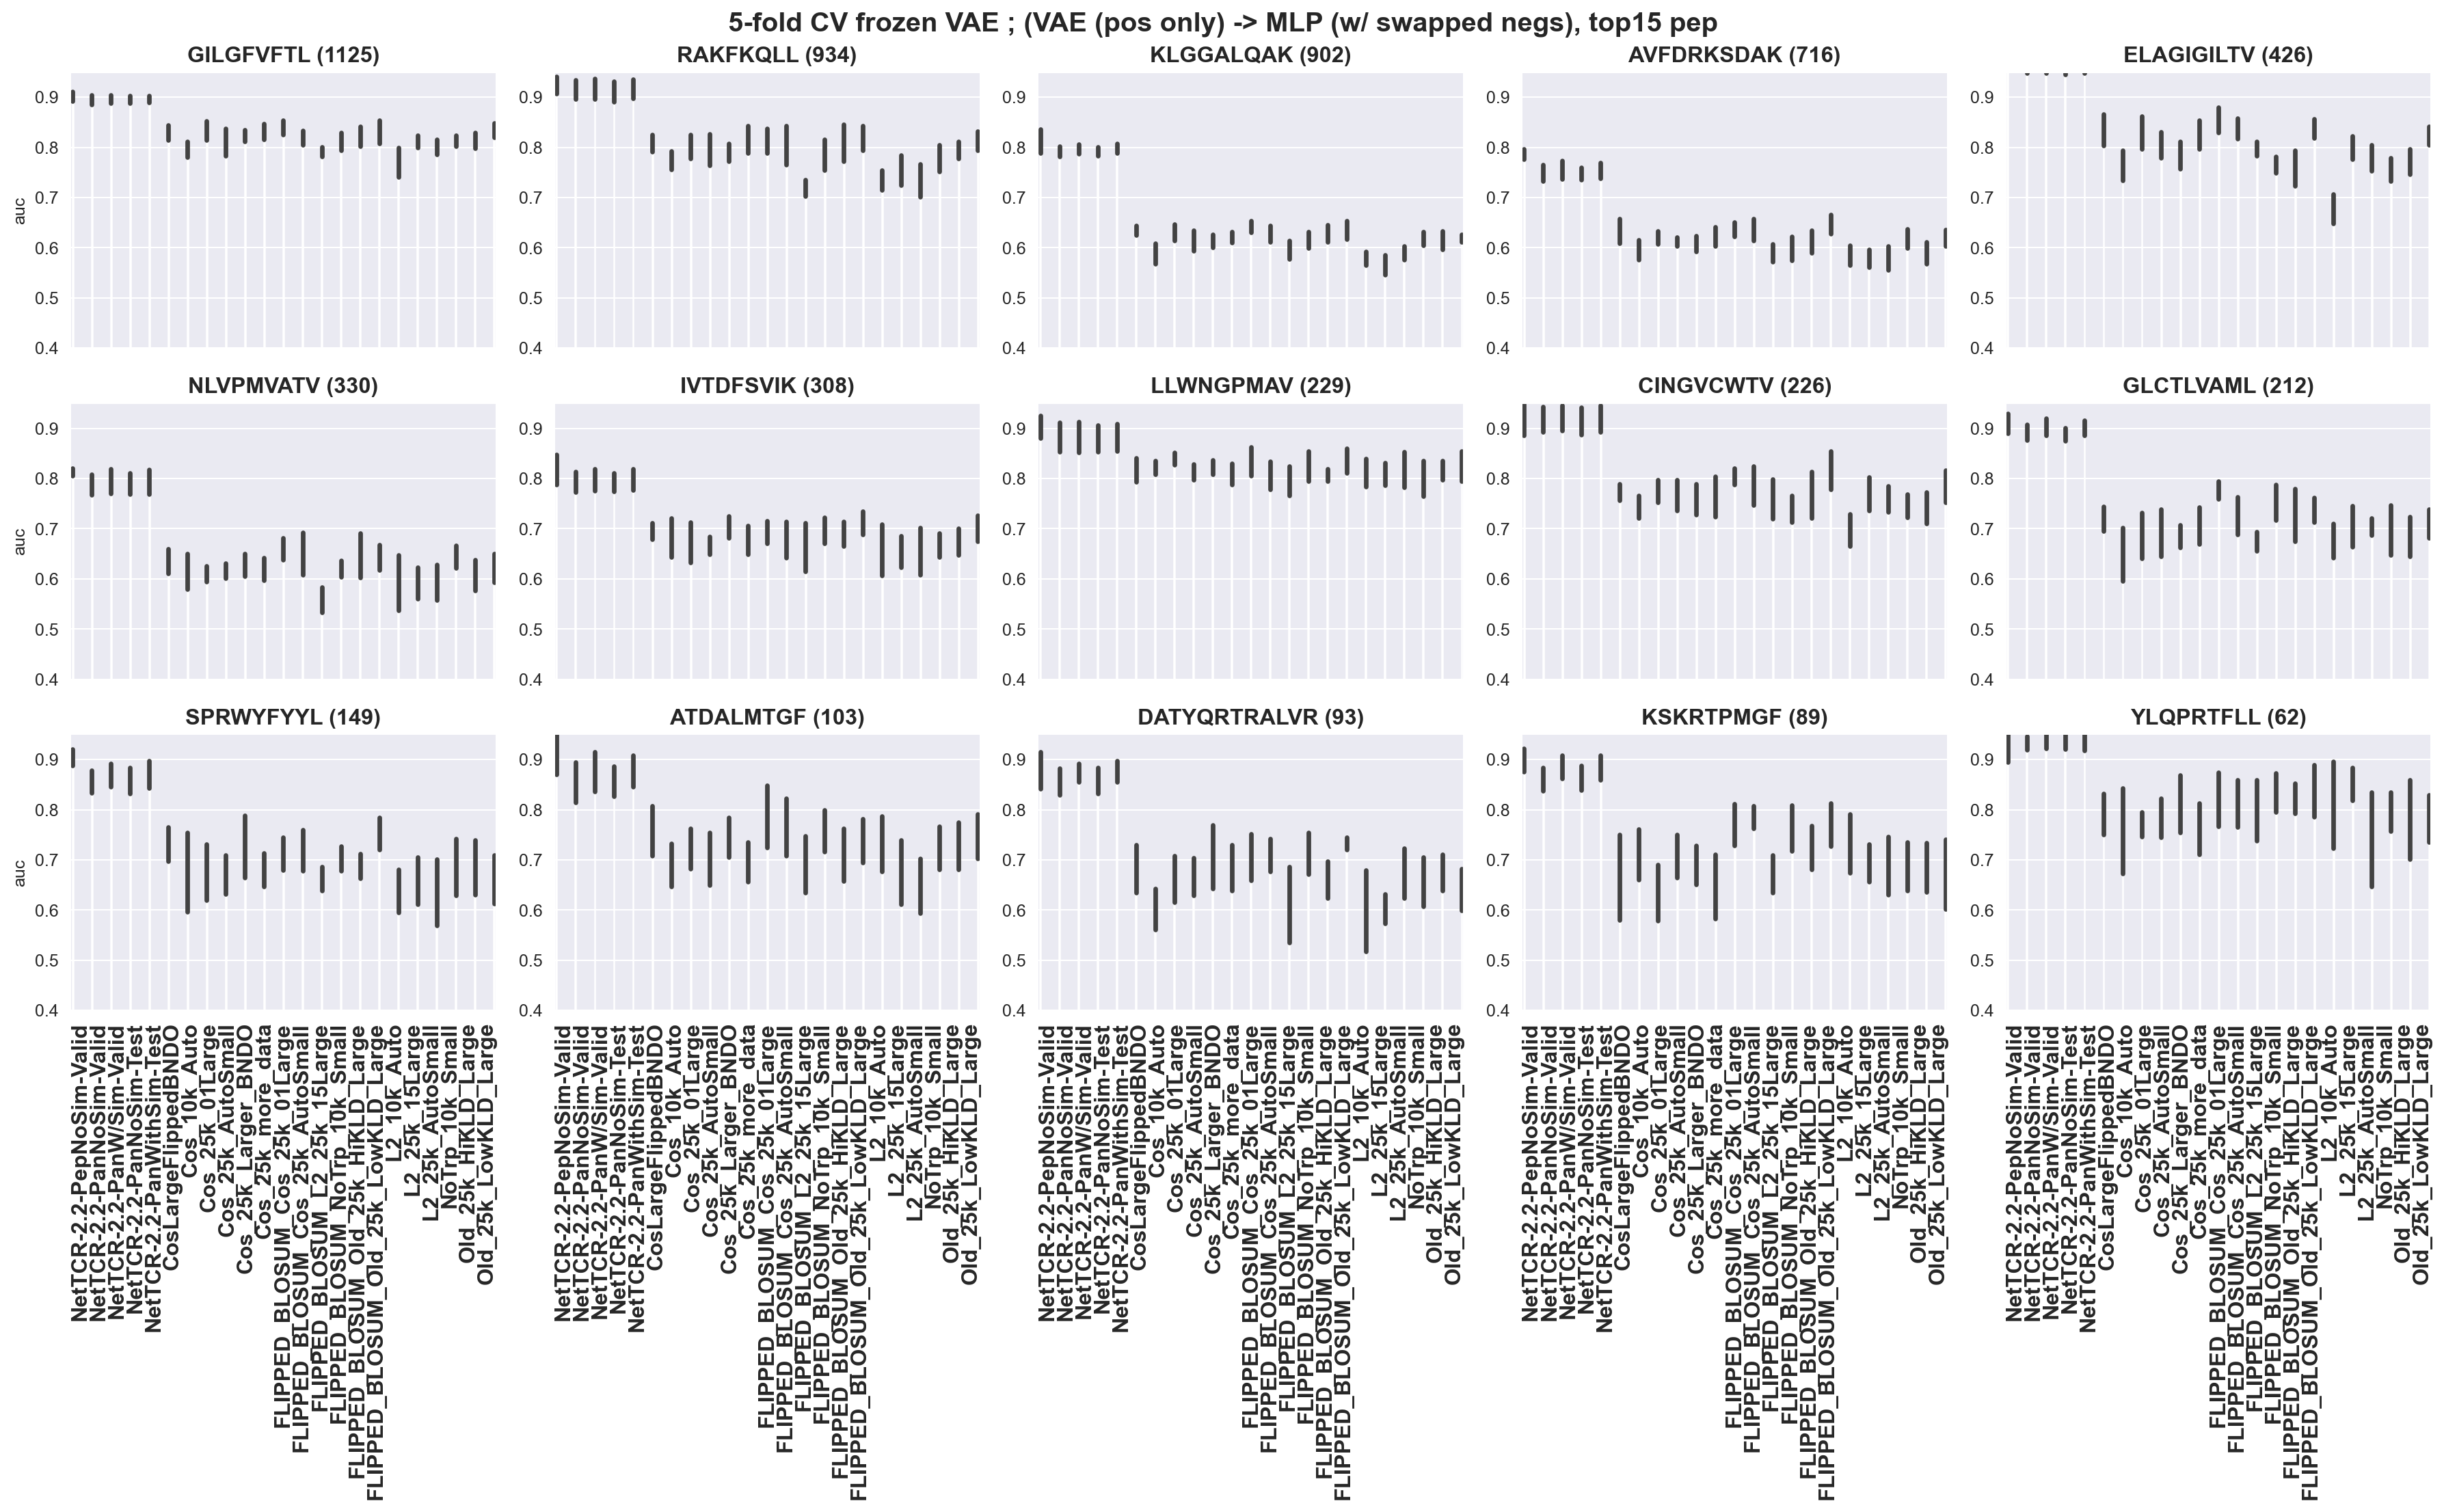

In [336]:
f,a = plt.subplots(3, 5, figsize=(20,12.5), sharex=True)
a = a.ravel()
xx = sorted([x for x in merged.name.unique() if 'nettcr' not in x.lower()])
yy = [x for x in merged.name.unique() if 'nettcr' in x.lower()]
order = yy+xx
sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.barplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

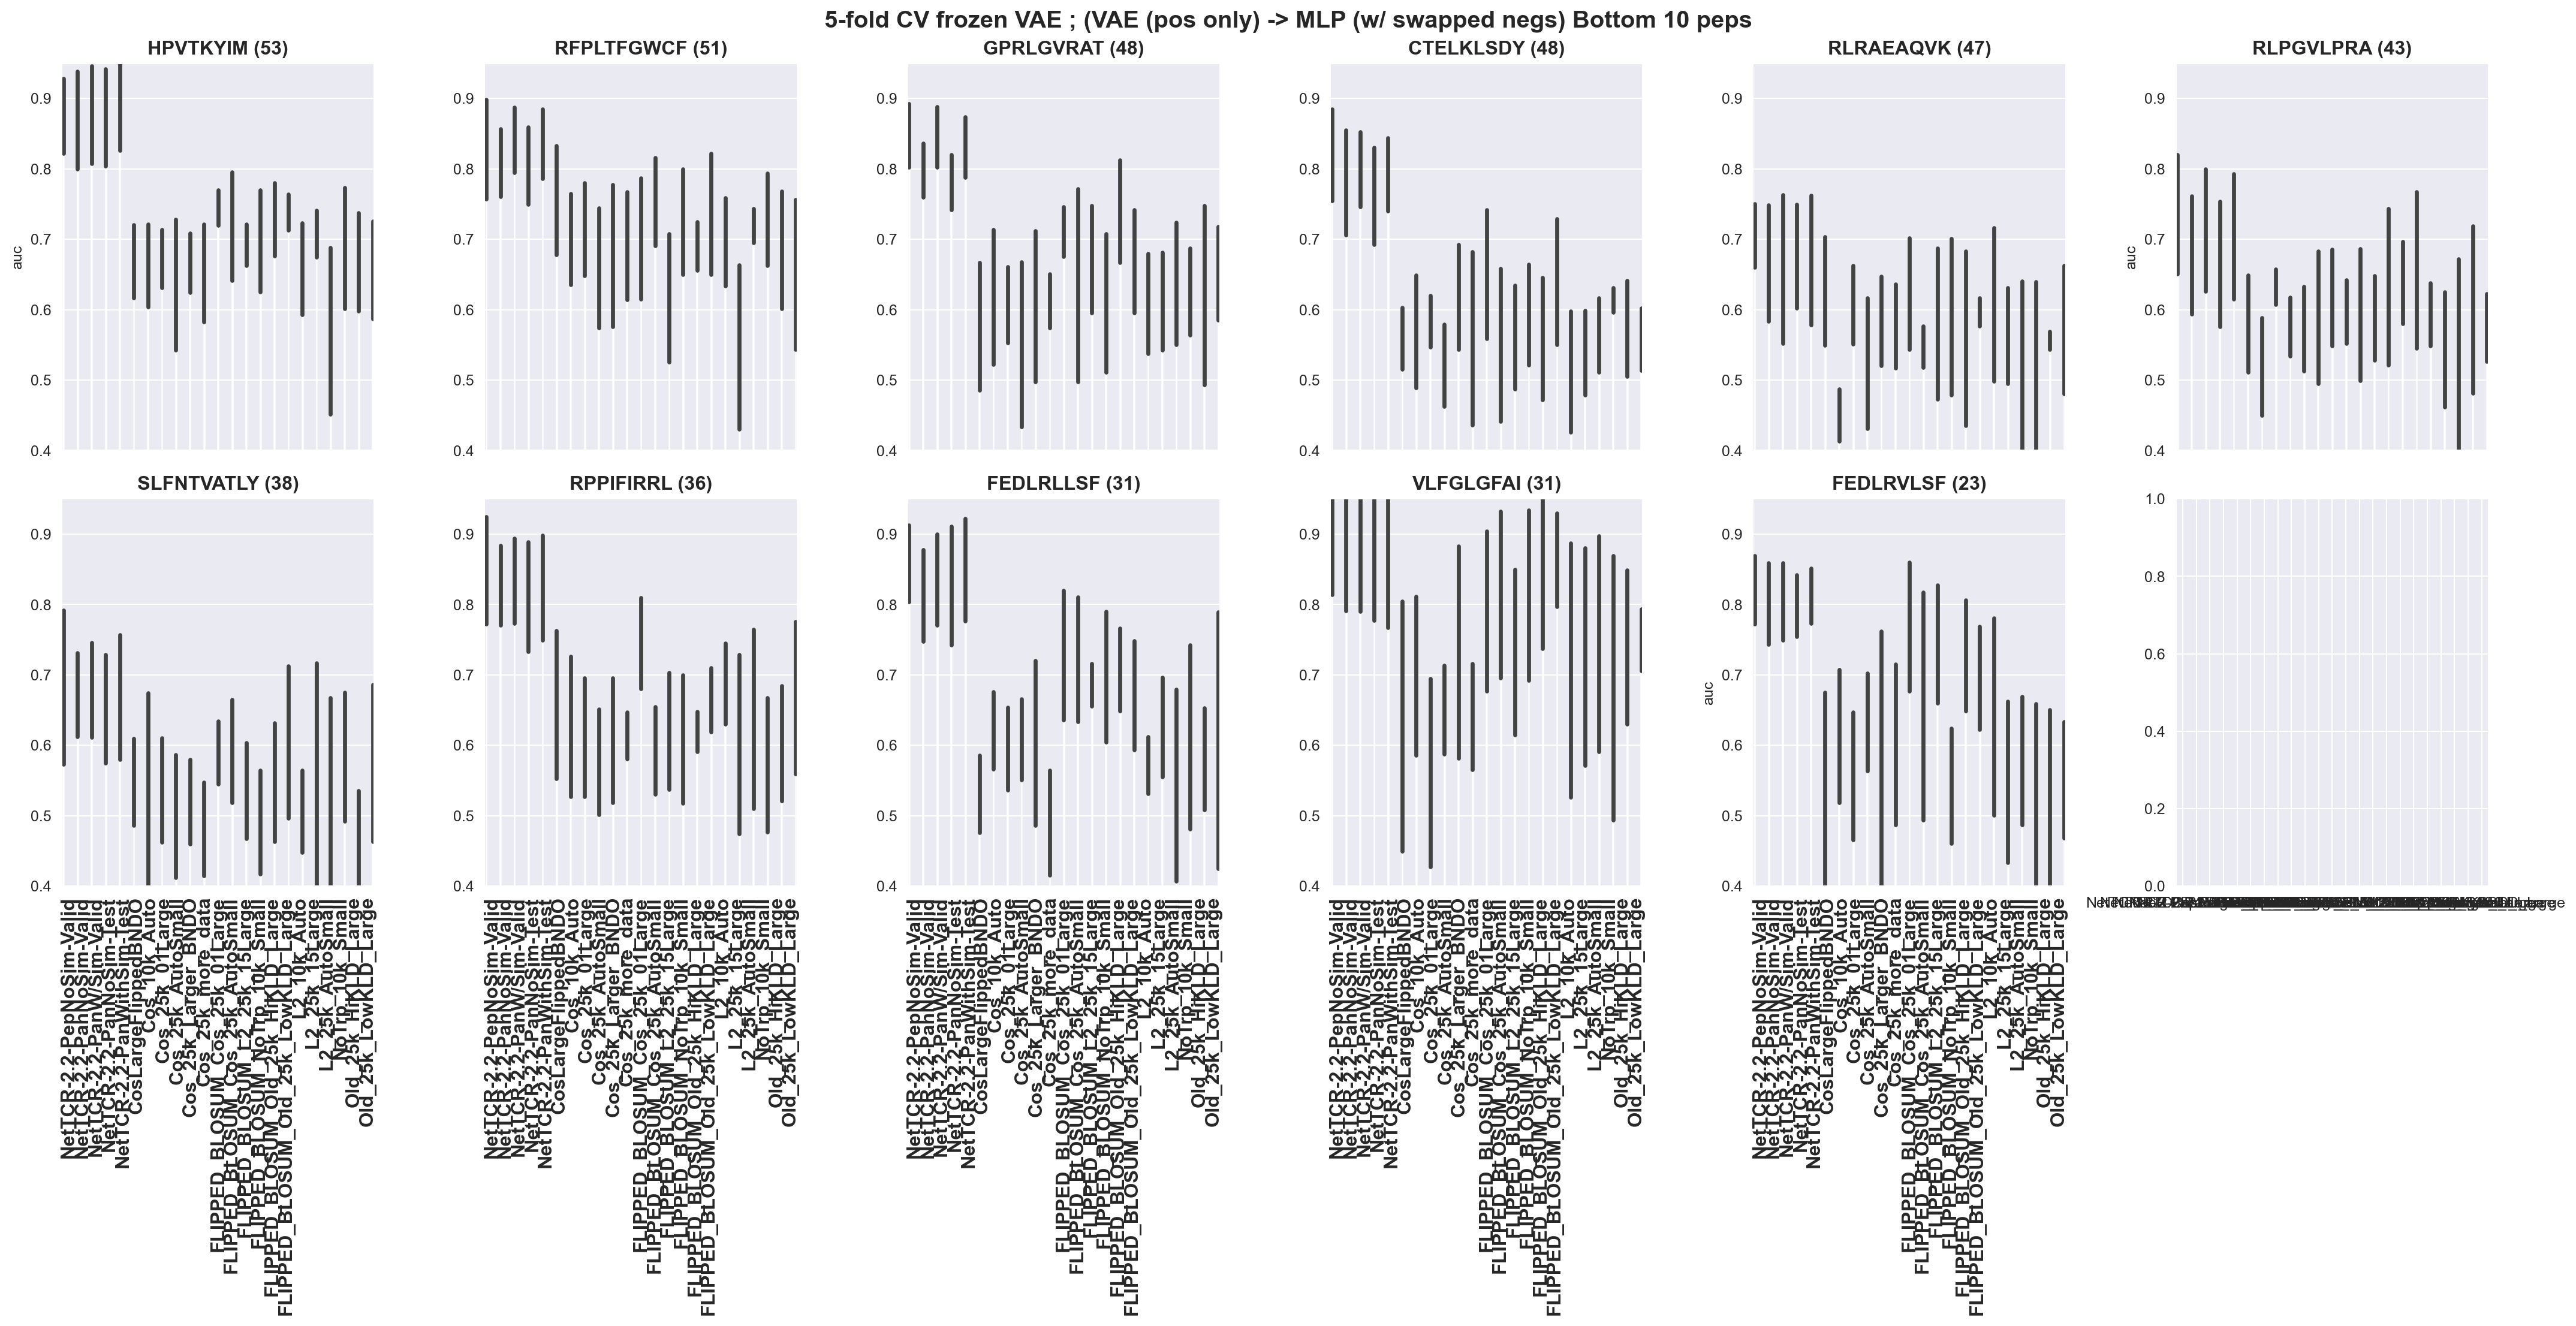

In [337]:
f,a = plt.subplots(2, 6, figsize=(24,12.5), sharex=True)
a = a.ravel()
xx = sorted([x for x in merged.name.unique() if 'nettcr' not in x.lower()])
yy = [x for x in merged.name.unique() if 'nettcr' in x.lower()]
order = yy+xx
sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.barplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

## here redo plot with only few models

In [331]:
merged.name.unique()

array(['FLIPPED_BLOSUM_NoTrp_10k_Small', 'FLIPPED_BLOSUM_L2_25k_15Large',
       'FLIPPED_BLOSUM_Old_25k_LowKLD_Large',
       'FLIPPED_BLOSUM_Cos_25k_01Large',
       'FLIPPED_BLOSUM_Cos_25k_AutoSmall',
       'FLIPPED_BLOSUM_Old_25k_HiKLD_Large', 'NoTrp_10k_Small',
       'Cos_25k_01Large', 'Cos_10k_Auto', 'Cos_25k_Larger_BNDO',
       'Cos_25k_more_data', 'CosLargeFlippedBNDO', 'Old_25k_LowKLD_Large',
       'L2_10k_Auto', 'Old_25k_HiKLD_Large', 'Cos_25k_AutoSmall',
       'L2_25k_15Large', 'L2_25k_AutoSmall', 'NetTCR-2.2-PepNoSim-Valid',
       'NetTCR-2.2-PanNoSim-Valid', 'NetTCR-2.2-PanW/Sim-Valid',
       'NetTCR-2.2-PanNoSim-Test', 'NetTCR-2.2-PanWithSim-Test'],
      dtype=object)

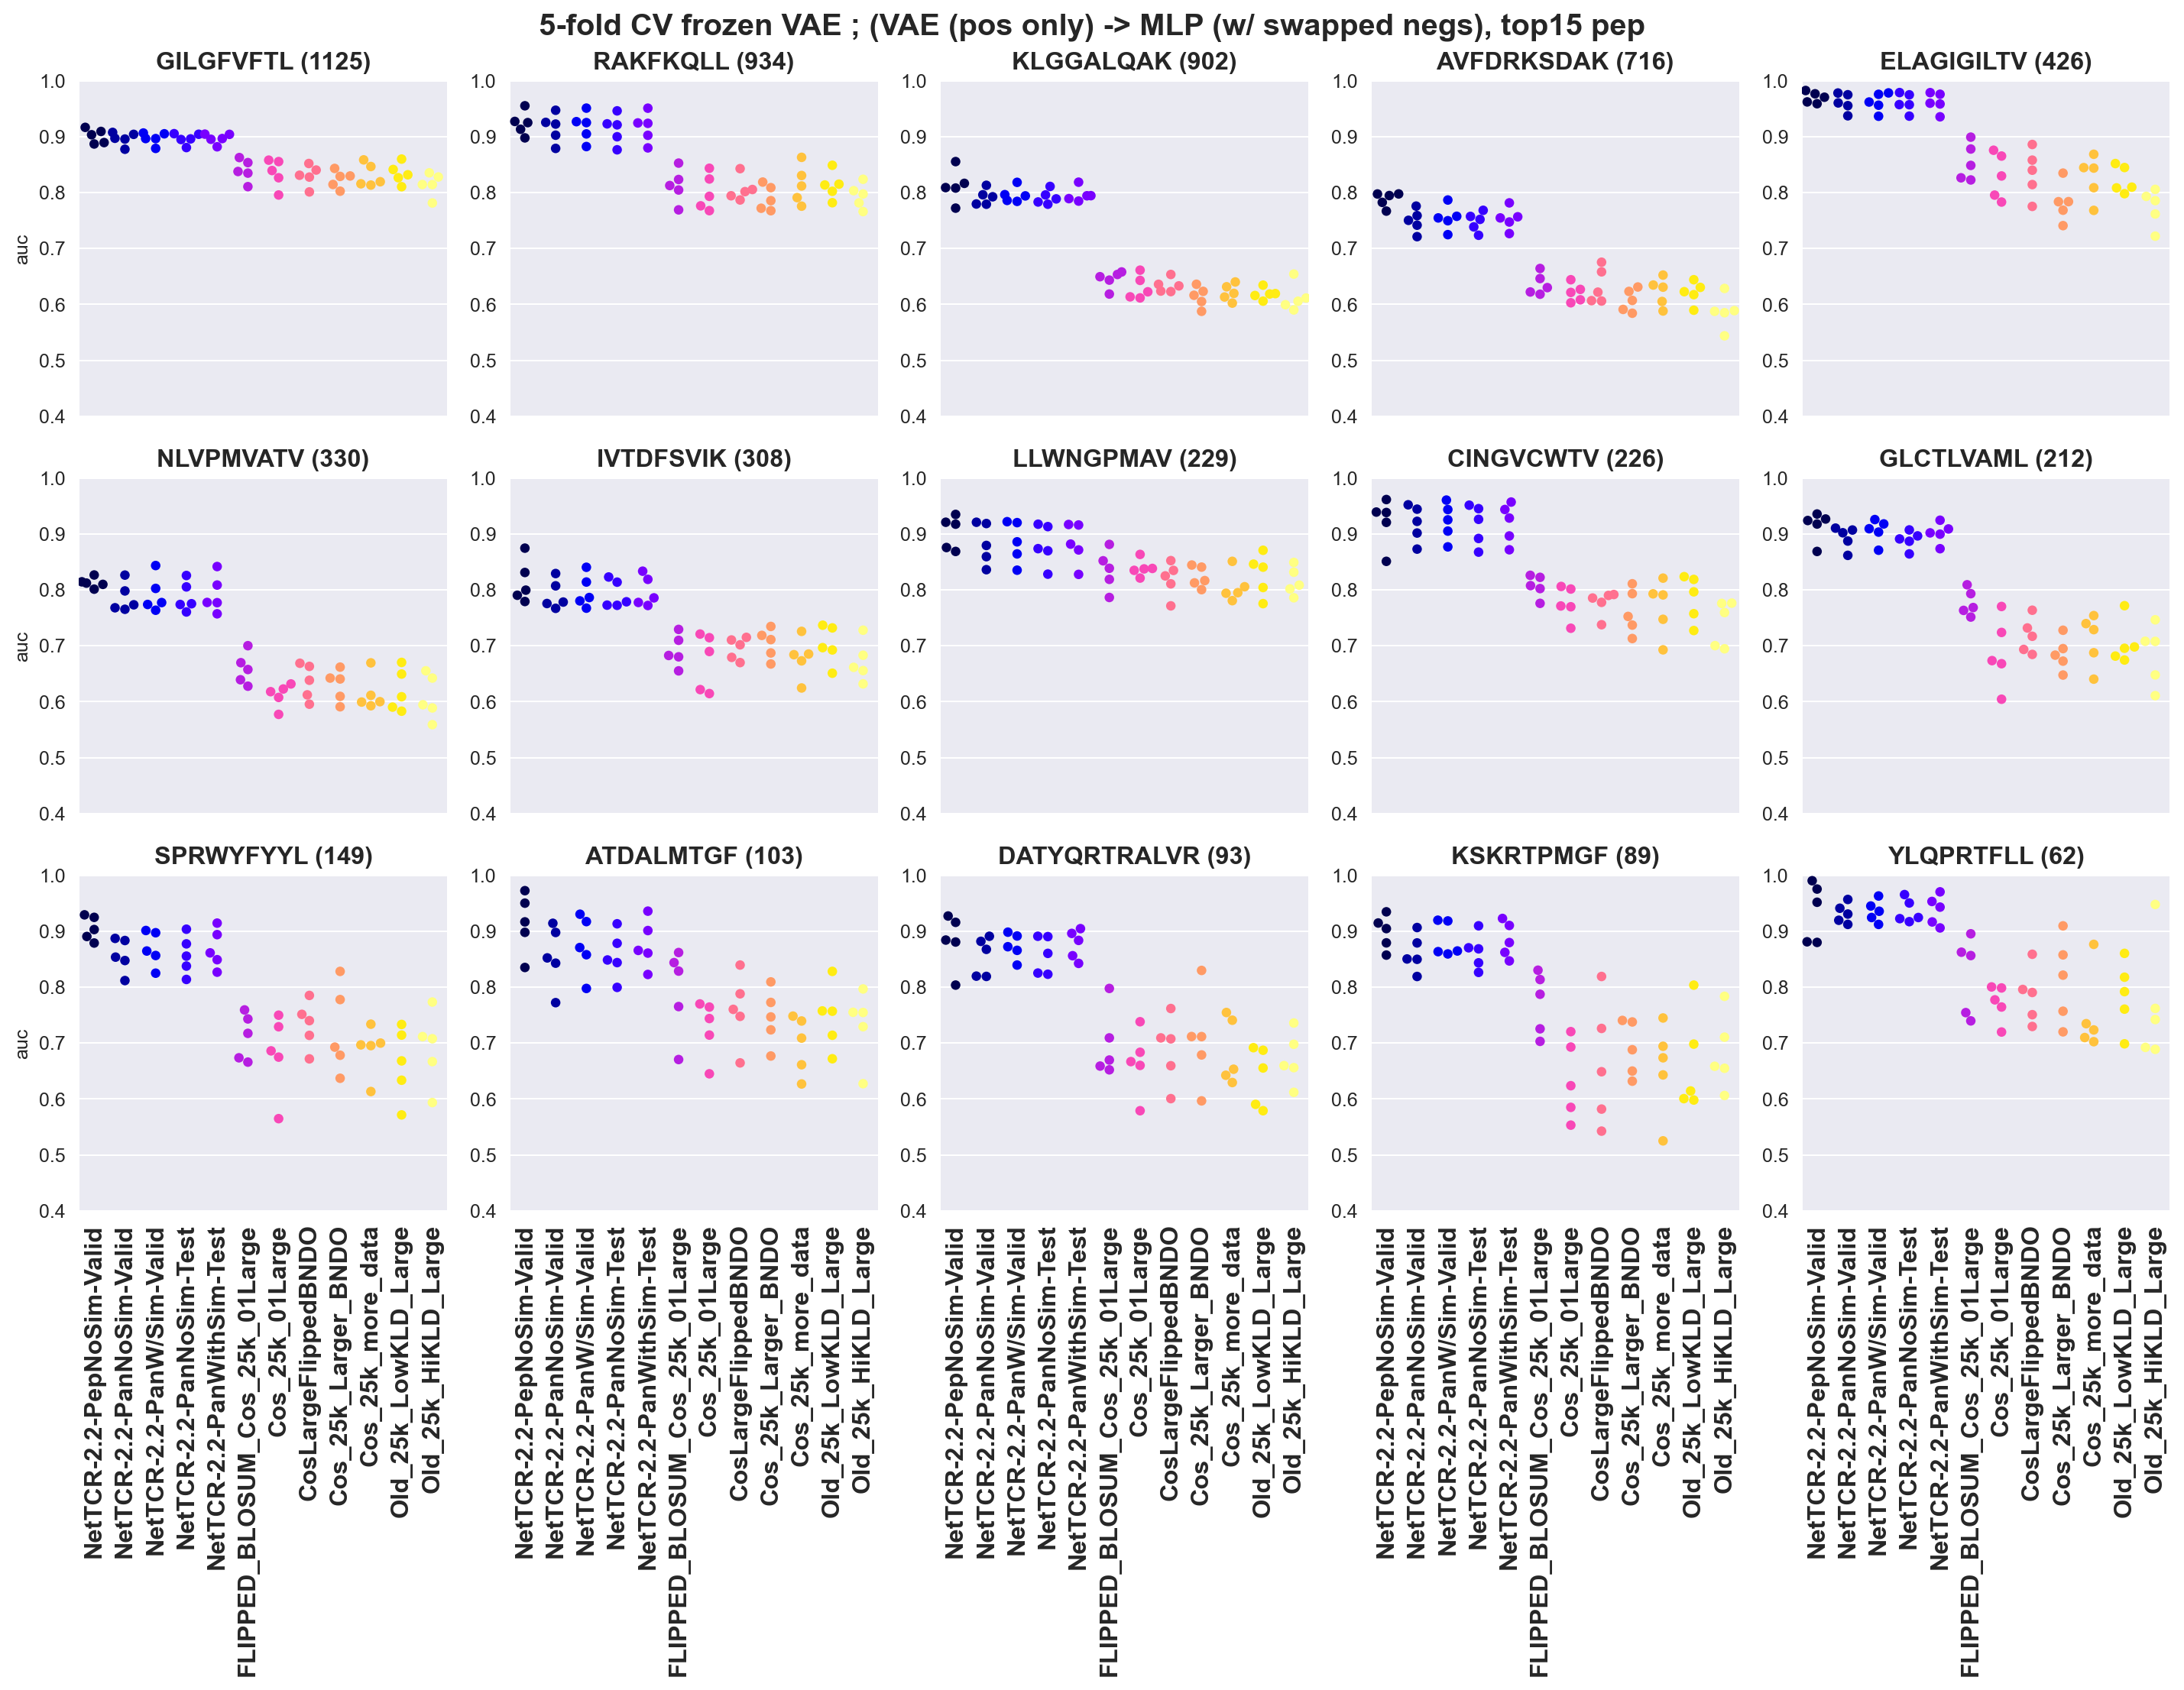

In [332]:
# AUC TOP 15 PEPS
f,a = plt.subplots(3, 5, figsize=(16,12.5), sharex=True)
a = a.ravel()

order = ['NetTCR-2.2-PepNoSim-Valid', 'NetTCR-2.2-PanNoSim-Valid', 'NetTCR-2.2-PanW/Sim-Valid', 'NetTCR-2.2-PanNoSim-Test', 'NetTCR-2.2-PanWithSim-Test',
         'FLIPPED_BLOSUM_Cos_25k_01Large',
         'Cos_25k_01Large', 'CosLargeFlippedBNDO', 'Cos_25k_Larger_BNDO', 'Cos_25k_more_data', 'Old_25k_LowKLD_Large', 'Old_25k_HiKLD_Large']
sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,1])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

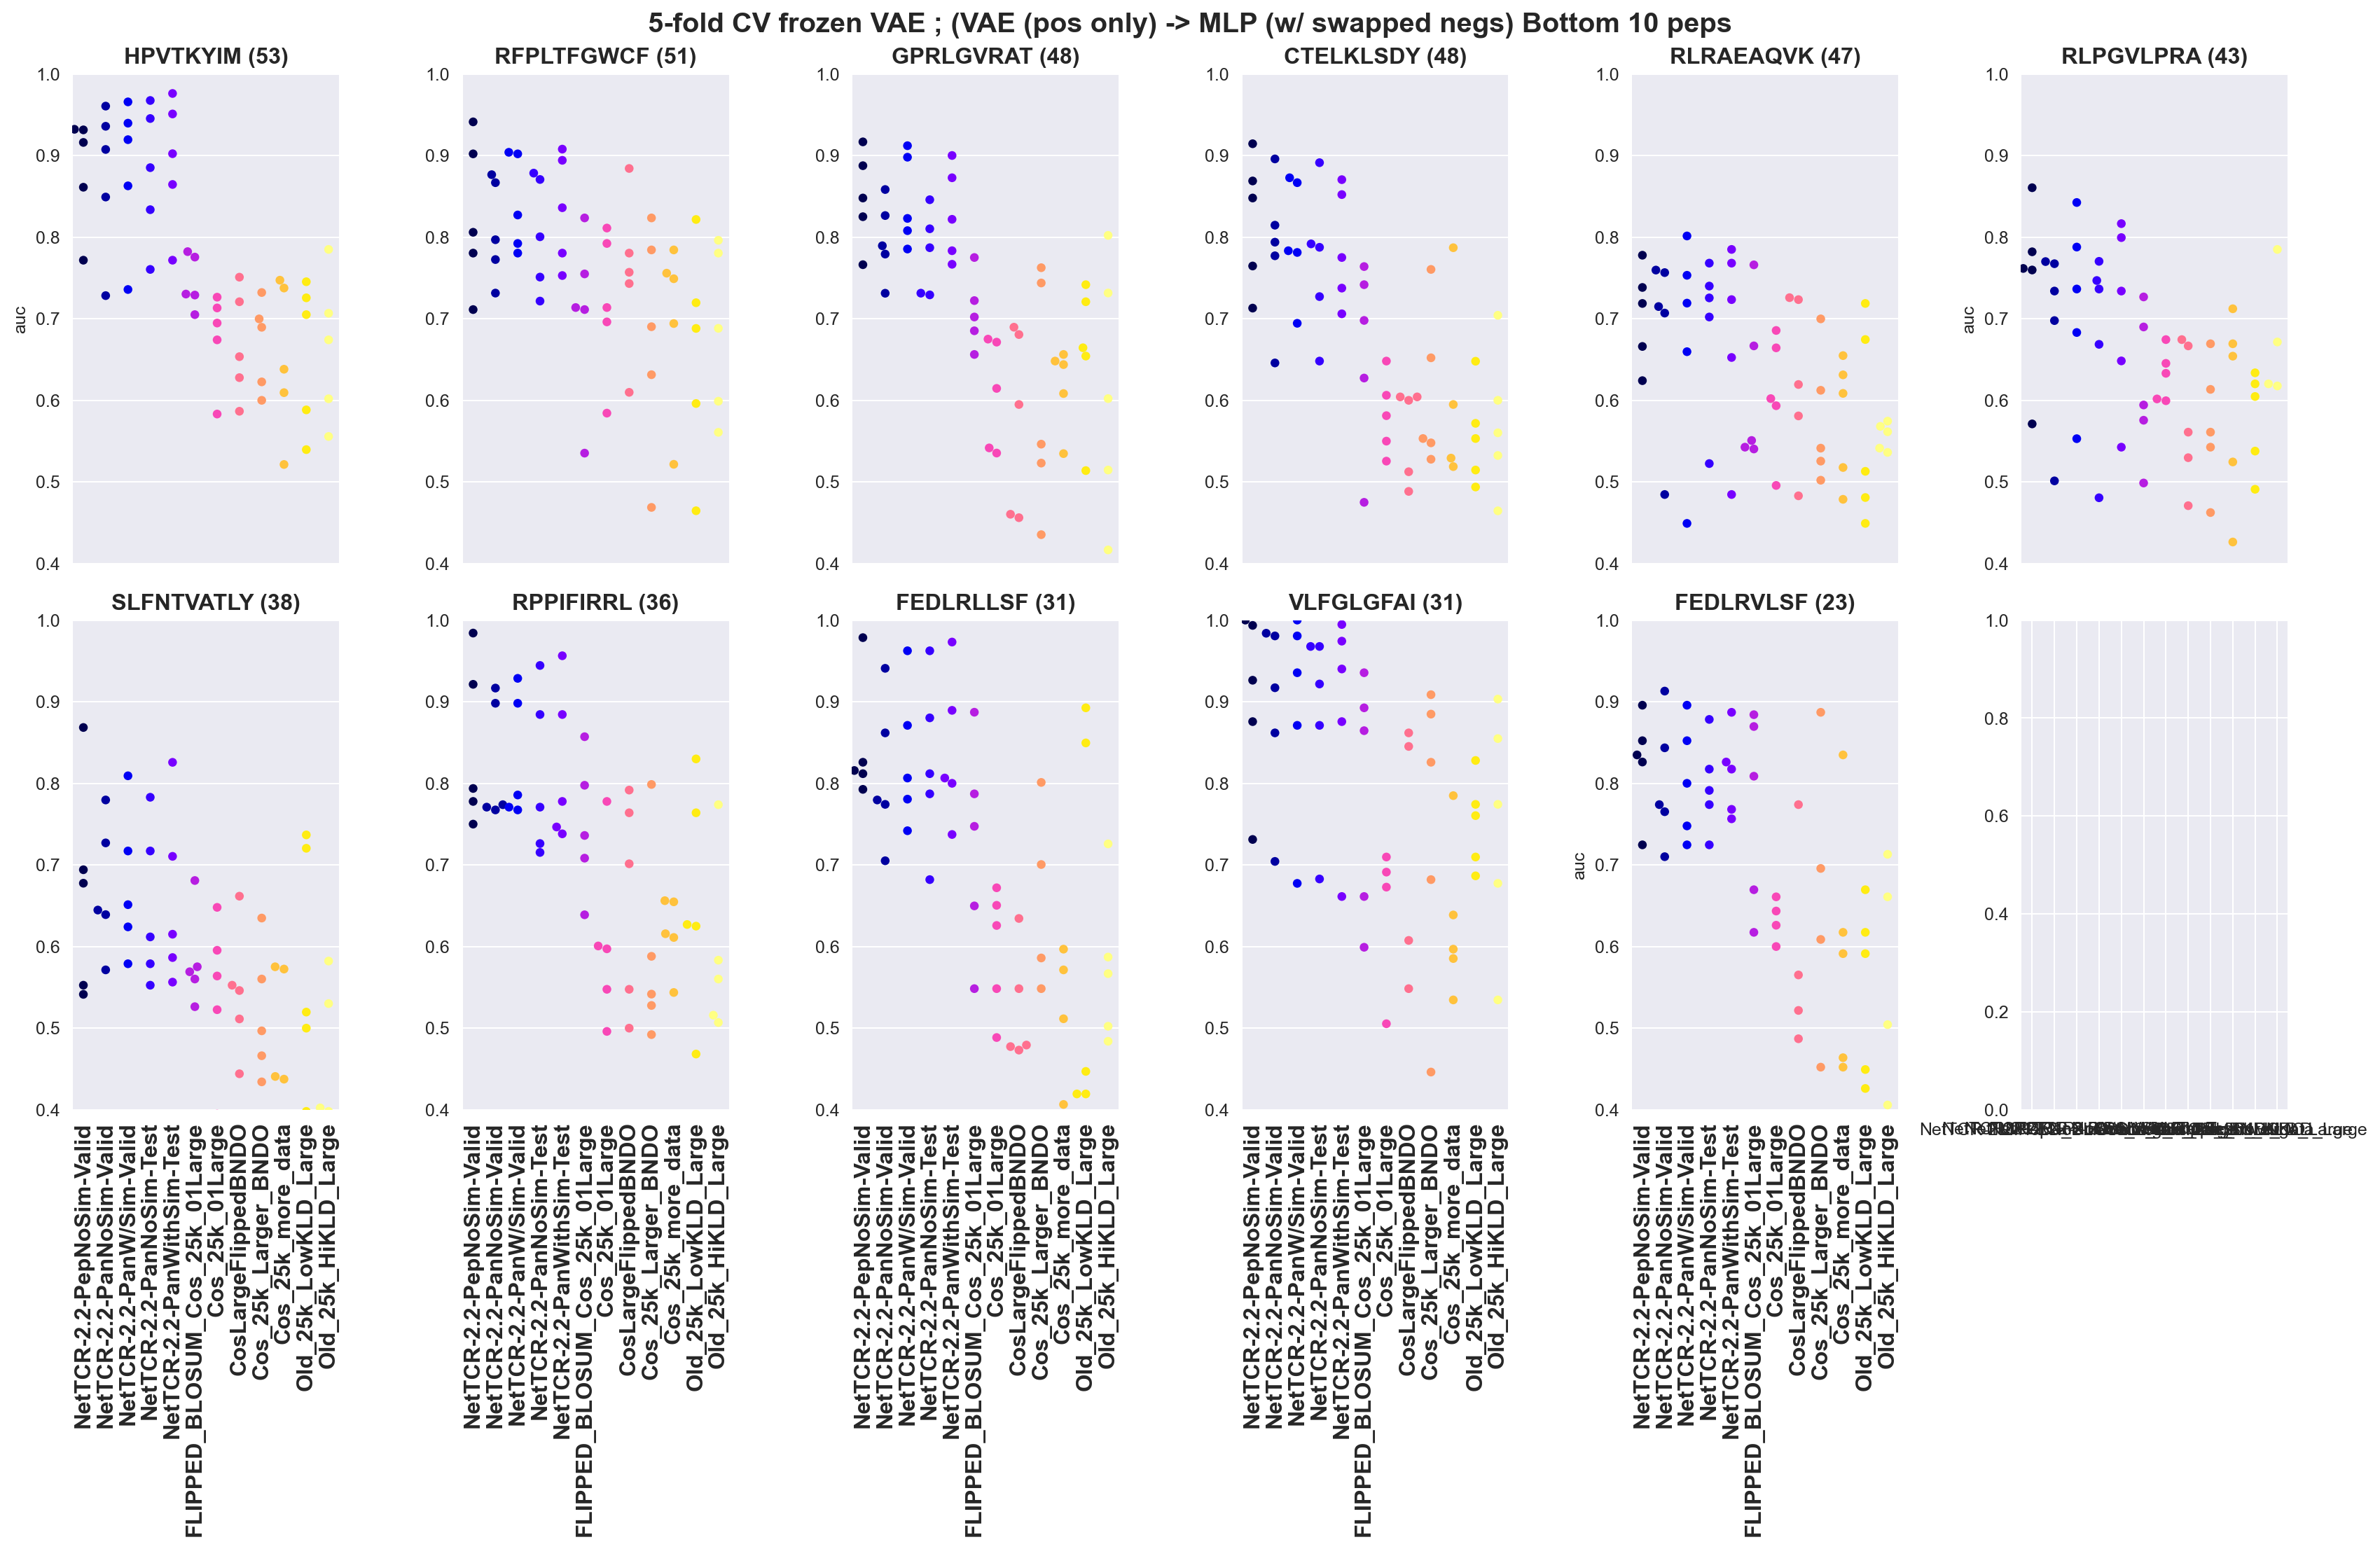

In [333]:
# AUC BOTTOM PEPS
f,a = plt.subplots(2, 6, figsize=(19,12.5), sharex=True)
a = a.ravel()

sns.set_palette(get_palette('gnuplot2', len(order)))

for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,1])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

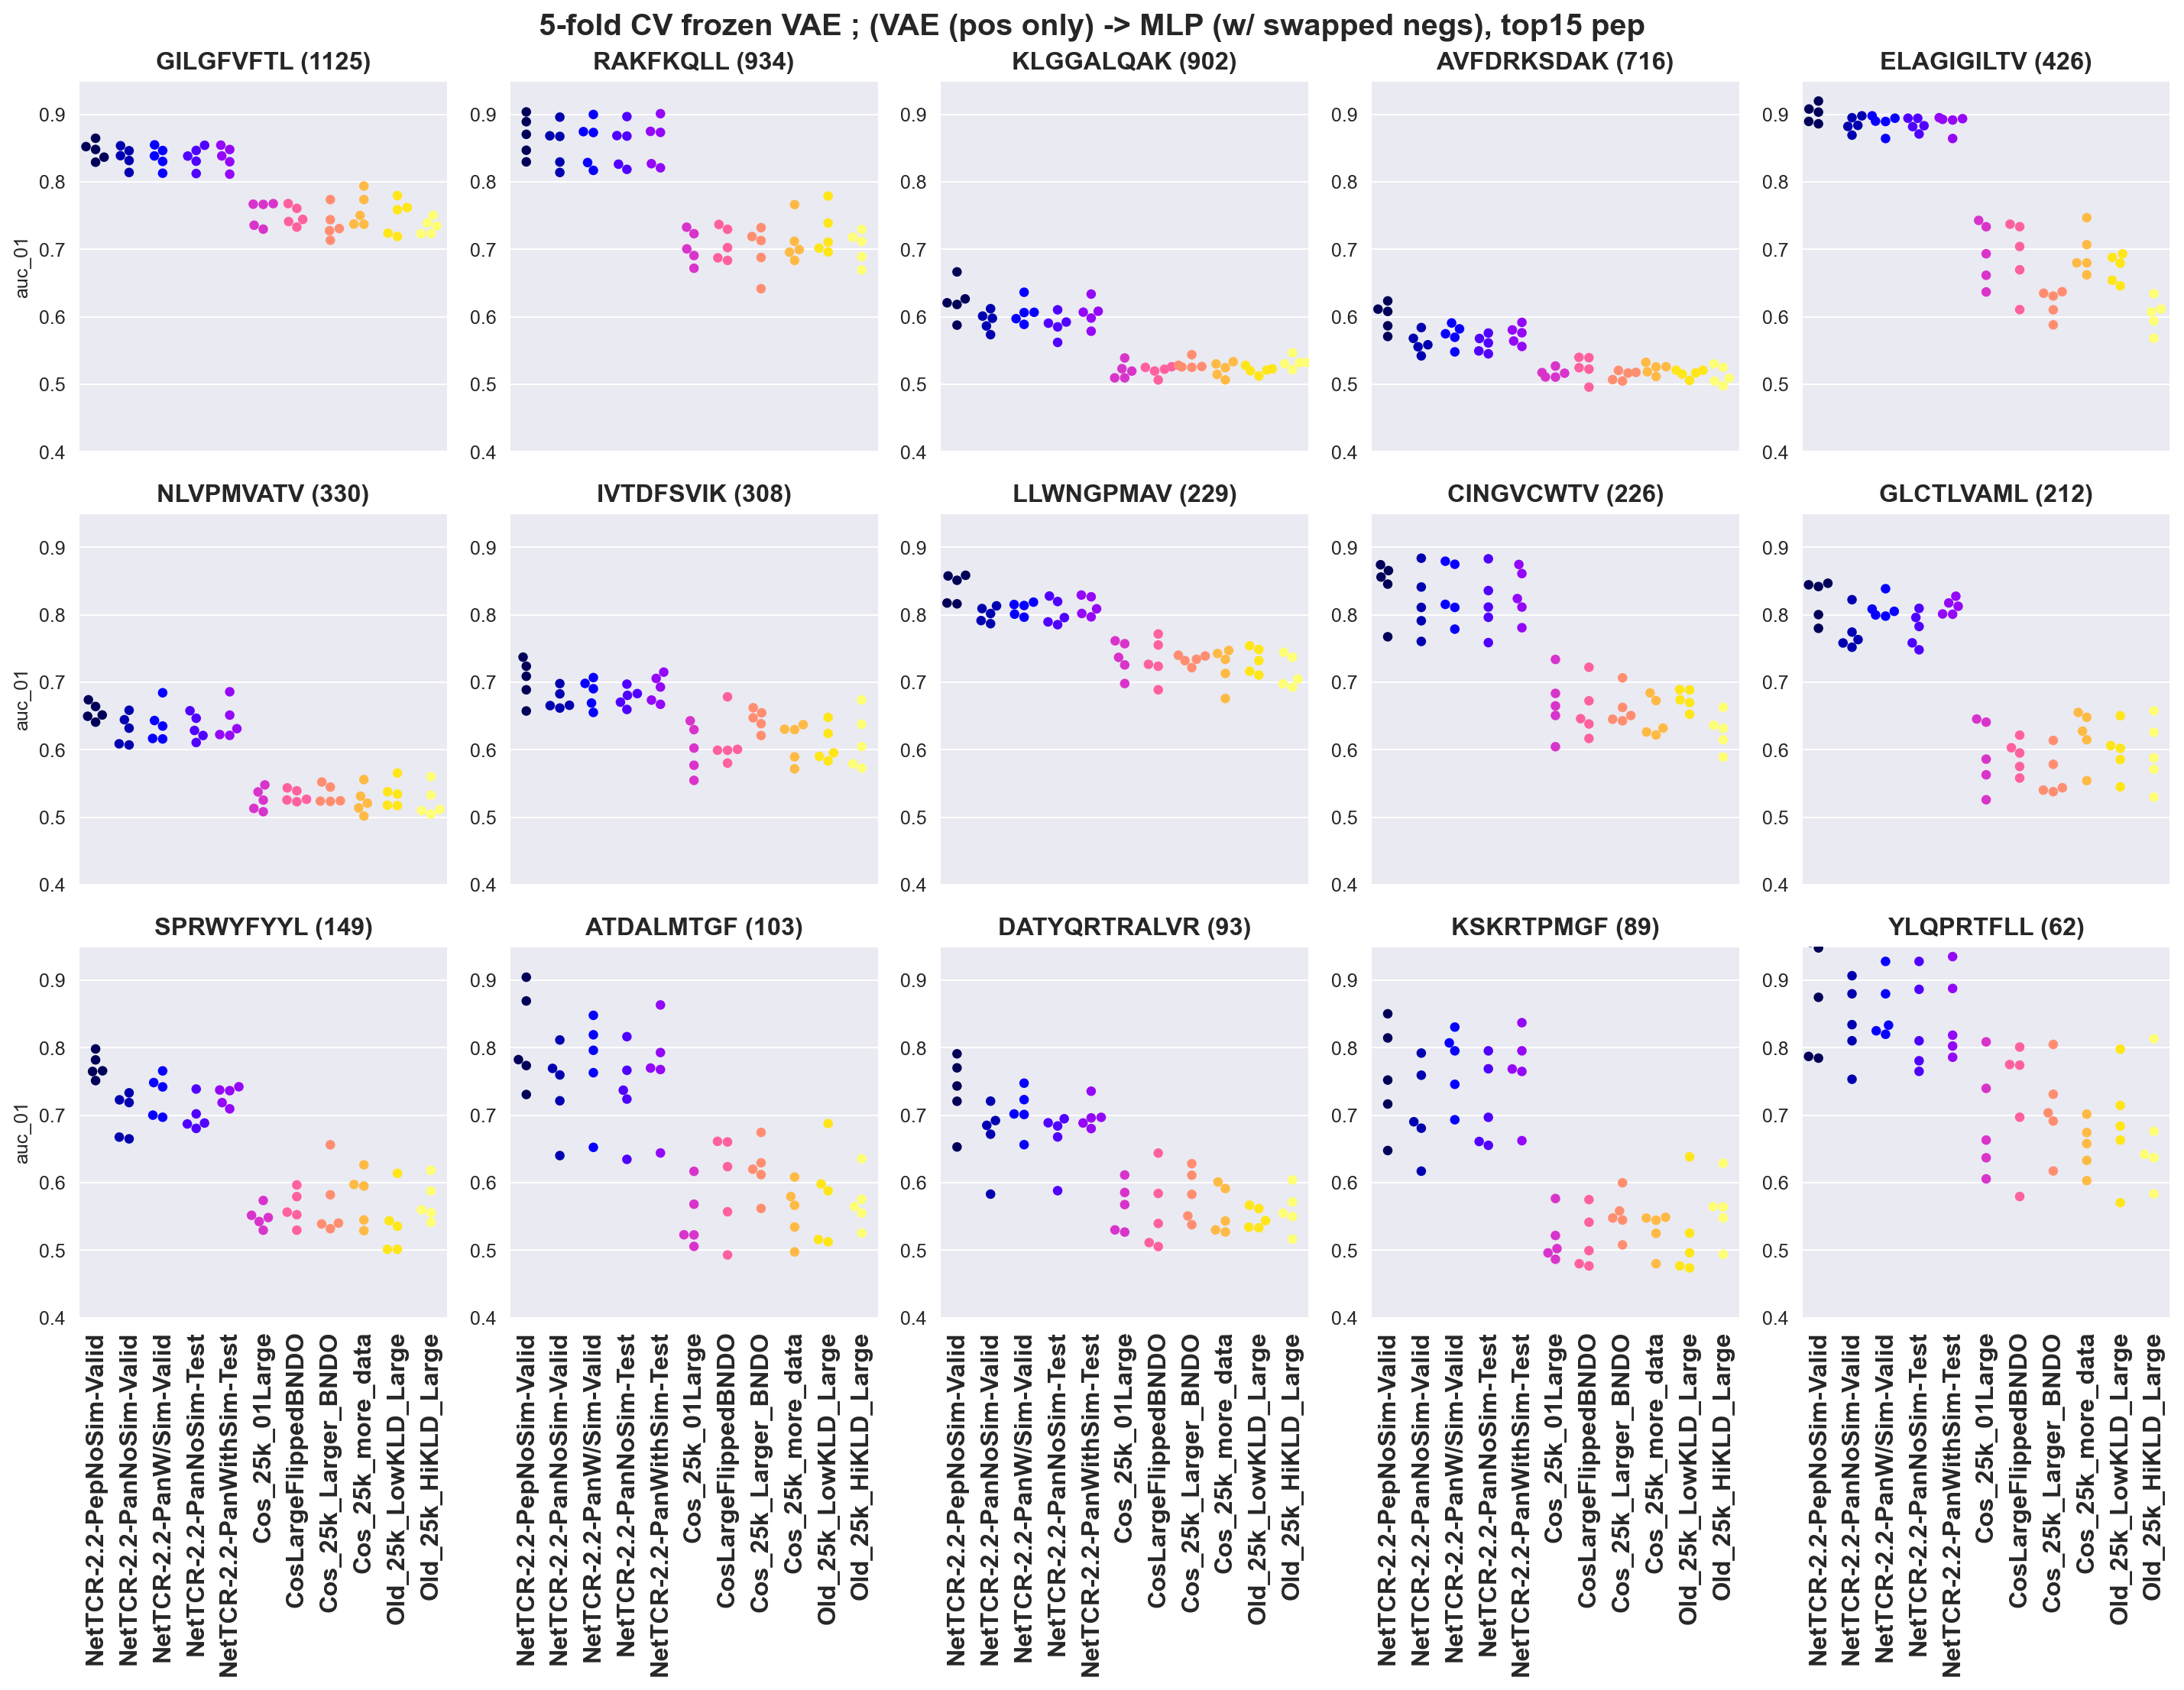

In [311]:
# AUC 01 TOP PEPS
f,a = plt.subplots(3, 5, figsize=(16,12.5), sharex=True)
a = a.ravel()


sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = clfs.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc_01', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

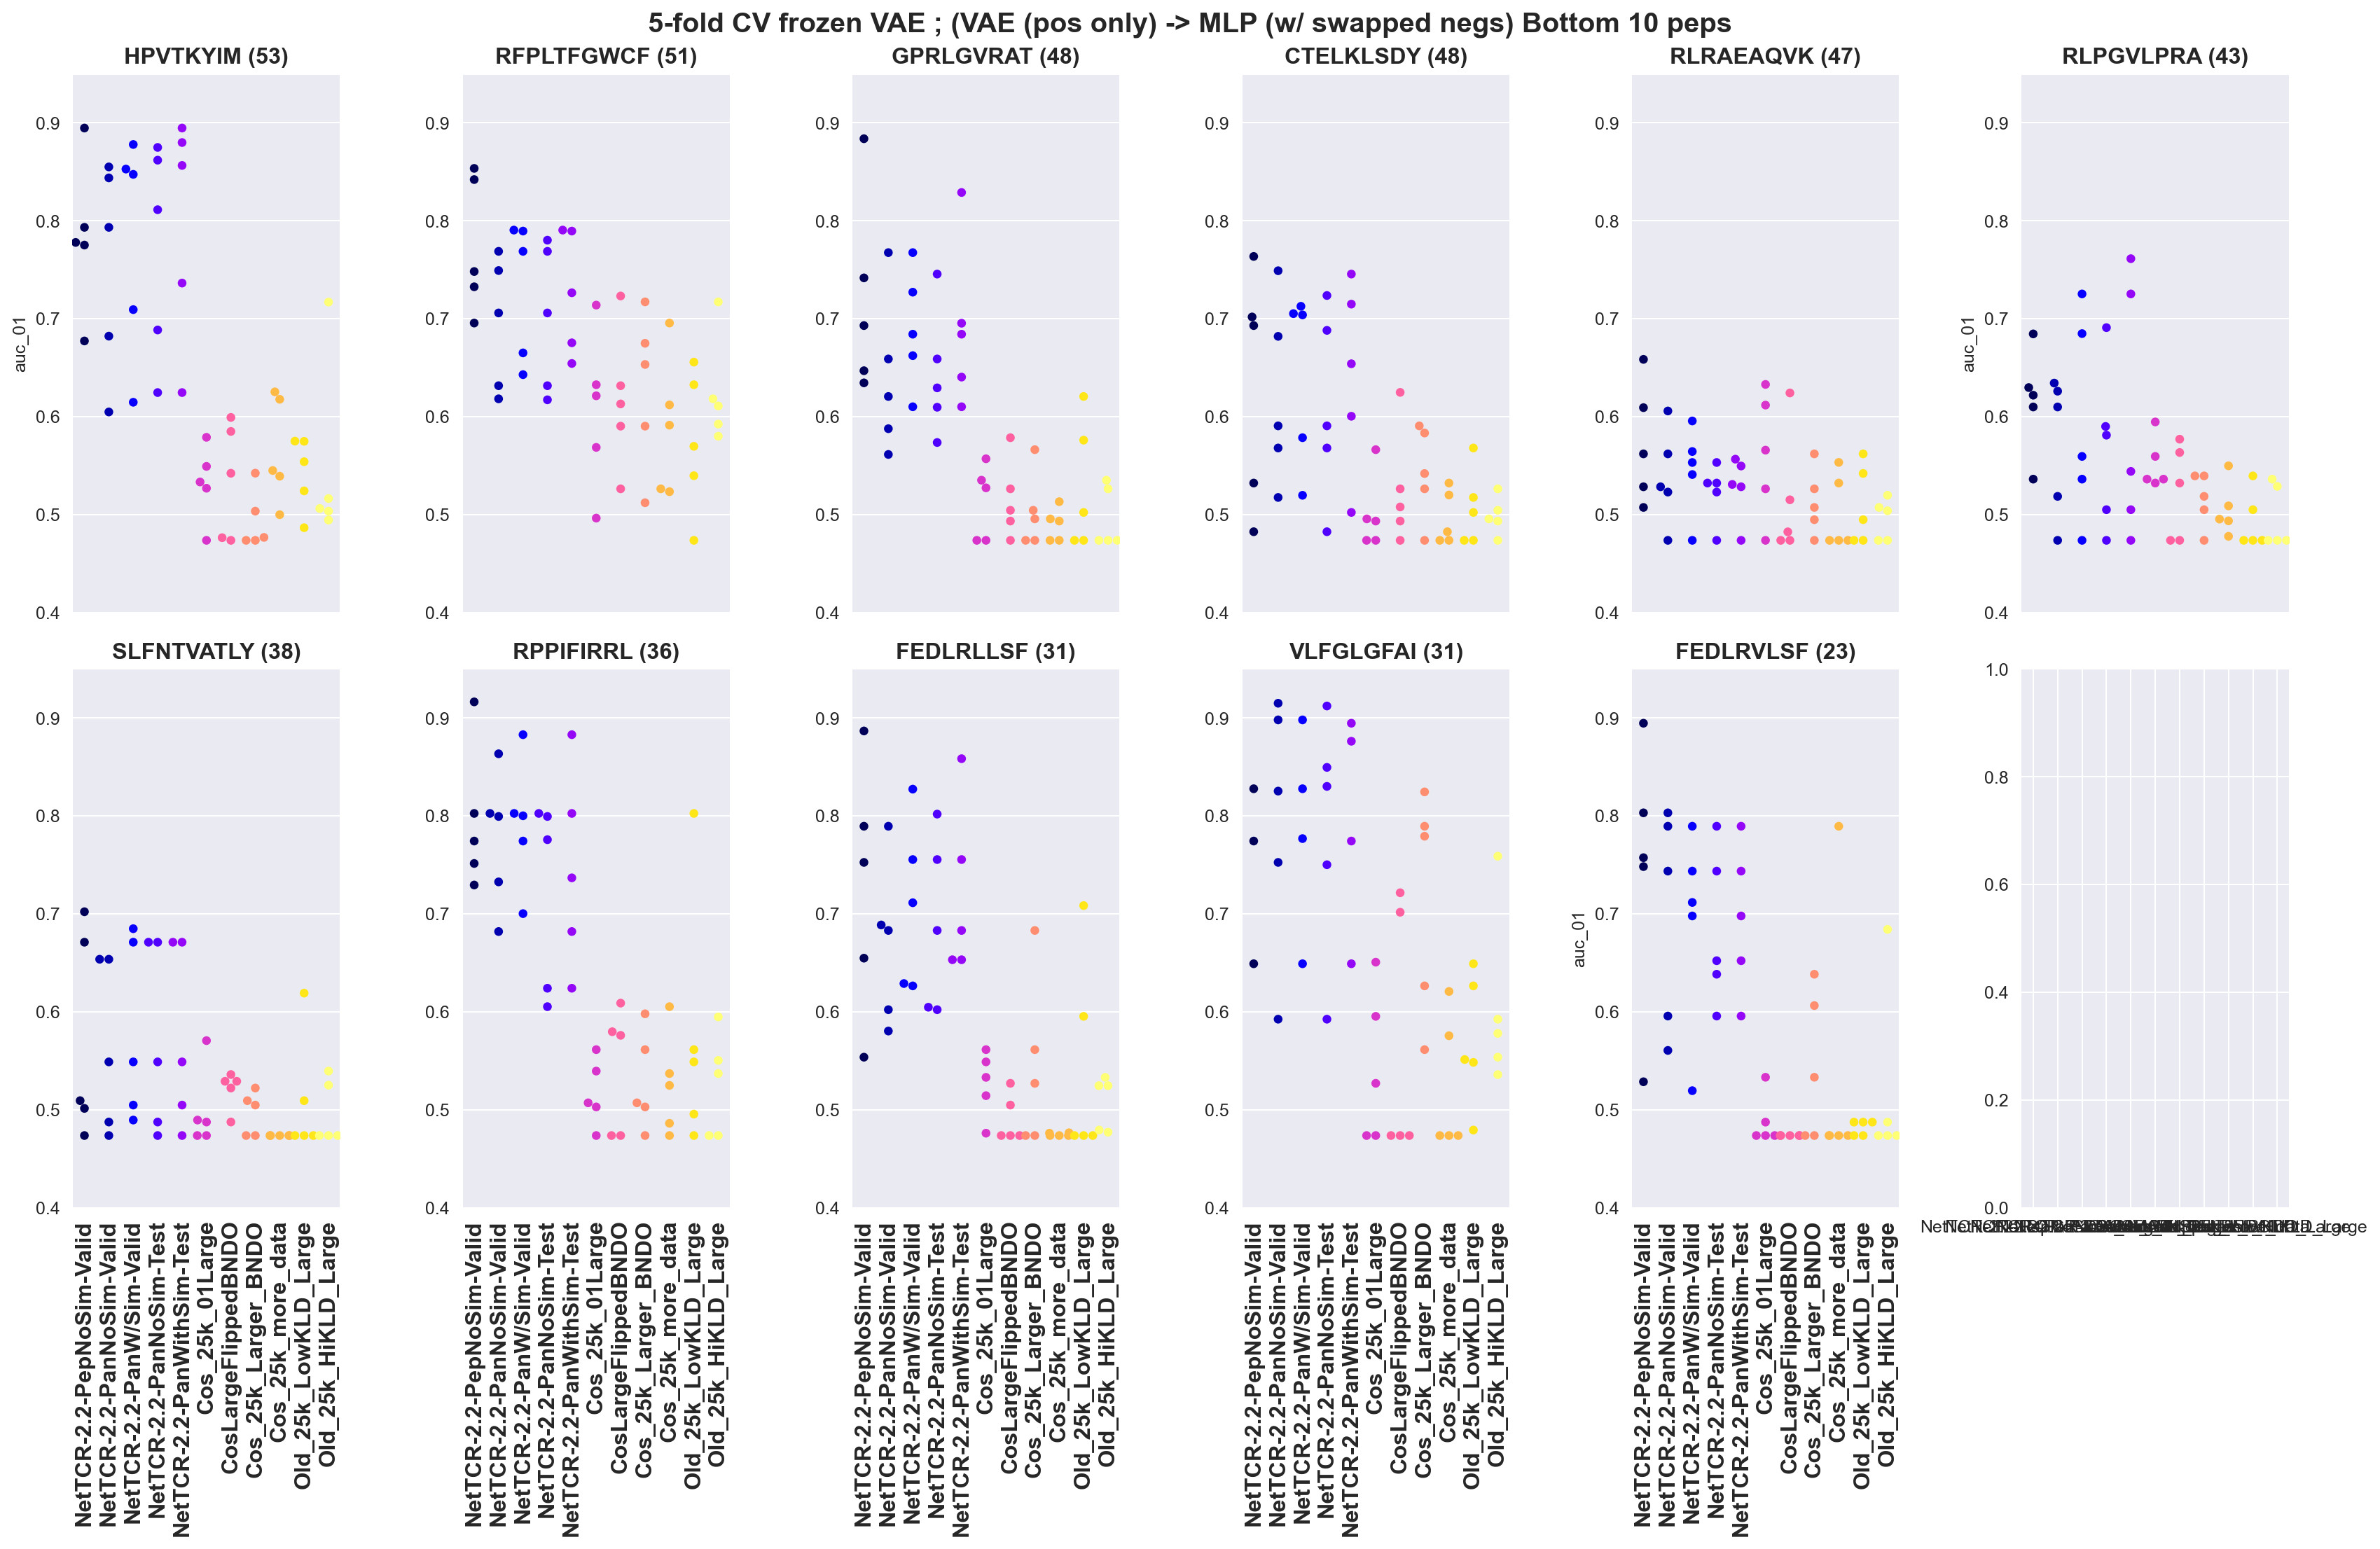

In [312]:
# AUC 01 BOTTOM 10 PEPS
f,a = plt.subplots(2, 6, figsize=(19,12.5), sharex=True)
a = a.ravel()

sns.set_palette(get_palette('gnuplot2', len(order)))

for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = clfs.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc_01', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

## wtf

In [271]:
clfs.query('peptide in @top10pep').groupby('name').agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), max_auc=('auc','max'),
                         mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std'), max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False) 

mean_auc   std_auc  max_auc  mean_auc01  std_auc01  \
name                                                                       
NetTCR-2.2-PepNoSim   0.876100  0.064710   0.9823    0.770302   0.110003   
NetTCR-2.2-PanW/Sim   0.862798  0.071765   0.9780    0.753638   0.112776   
NetTCR-2.2-PanNoSim   0.858552  0.072370   0.9778    0.743014   0.114497   
CosLargeFlippedBNDO   0.738154  0.085135   0.8858    0.631902   0.088849   
Old_25k_LowKLD_Large  0.734542  0.092338   0.8706    0.633078   0.088810   
Cos_25k_01Large       0.730204  0.096217   0.8755    0.631108   0.092305   
Cos_25k_more_data     0.729132  0.091944   0.8683    0.633640   0.088524   
Cos_25k_Larger_BNDO   0.721826  0.085233   0.8442    0.623648   0.083935   
Cos_25k_AutoSmall     0.719248  0.089661   0.8548    0.621646   0.083967   
NoTrp_10k_Small       0.713934  0.078494   0.8621    0.610524   0.071739   
Old_25k_HiKLD_Large   0.710082  0.090761   0.8489    0.616092   0.081008   
L2_25k_15Large        0.703620  0.102407   0.8415    0.618416   0.080178   
Cos_10k_Auto          0.703154  0.091363   0.8414    0.610066   0.078207   
L2_25k_AutoSmall      0.700930  0.093760   0.8816    0.612800   0.079765   
L2_10k_Auto           0.678214  0.085395   0.8668    0.587072   0.070732   

                      max_auc01  
name                             
NetTCR-2.2-PepNoSim      0.9197  
NetTCR-2.2-PanW/Sim      0.8998  
NetTCR-2.2-PanNoSim      0.8978  
CosLargeFlippedBNDO      0.7715  
Old_25k_LowKLD_Large     0.7797  
Cos_25k_01Large          0.7677  
Cos_25k_more_data        0.7938  
Cos_25k_Larger_BNDO      0.7737  
Cos_25k_AutoSmall        0.7585  
NoTrp_10k_Small          0.7488  
Old_25k_HiKLD_Large      0.7505  
L2_25k_15Large           0.7486  
Cos_10k_Auto             0.7531  
L2_25k_AutoSmall         0.7384  
L2_10k_Auto              0.7676

In [274]:
clfs.query('peptide not in @top10pep').groupby('name').agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), max_auc=('auc','max'),
                         mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std'), max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False)

mean_auc   std_auc  max_auc  mean_auc01  std_auc01  \
name                                                                       
NetTCR-2.2-PepNoSim   0.841066  0.102374   1.0000    0.733251   0.120969   
NetTCR-2.2-PanW/Sim   0.827555  0.103153   1.0000    0.714736   0.113042   
NetTCR-2.2-PanNoSim   0.812950  0.100500   0.9839    0.686420   0.110273   
Cos_25k_Larger_BNDO   0.650150  0.138538   0.9094    0.566279   0.085630   
L2_10k_Auto           0.648728  0.131975   0.9395    0.551875   0.074422   
Old_25k_LowKLD_Large  0.645210  0.121071   0.8925    0.544691   0.076319   
CosLargeFlippedBNDO   0.642789  0.127782   0.8841    0.549070   0.080708   
NoTrp_10k_Small       0.638081  0.139327   0.9086    0.557719   0.076131   
Cos_25k_01Large       0.638070  0.097520   0.8111    0.544355   0.064928   
Old_25k_HiKLD_Large   0.633681  0.126864   0.9476    0.546591   0.071439   
L2_25k_15Large        0.631258  0.129639   0.9462    0.554980   0.088910   
Cos_10k_Auto          0.625895  0.124799   0.8965    0.553144   0.072452   
Cos_25k_more_data     0.624090  0.110807   0.8763    0.534956   0.066934   
Cos_25k_AutoSmall     0.623684  0.113312   0.8508    0.544655   0.069427   
L2_25k_AutoSmall      0.622762  0.140300   0.9161    0.559925   0.082146   

                      max_auc01  
name                             
NetTCR-2.2-PepNoSim      1.0000  
NetTCR-2.2-PanW/Sim      1.0000  
NetTCR-2.2-PanNoSim      0.9151  
Cos_25k_Larger_BNDO      0.8246  
L2_10k_Auto              0.8062  
Old_25k_LowKLD_Large     0.8026  
CosLargeFlippedBNDO      0.8009  
NoTrp_10k_Small          0.8175  
Cos_25k_01Large          0.8086  
Old_25k_HiKLD_Large      0.8132  
L2_25k_15Large           0.8557  
Cos_10k_Auto             0.8260  
Cos_25k_more_data        0.7895  
Cos_25k_AutoSmall        0.8401  
L2_25k_AutoSmall         0.8947

In [272]:
clfs.groupby(['name']).agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std')).sort_values('mean_auc',ascending=False)

mean_auc   std_auc  mean_auc01  std_auc01
name                                                           
NetTCR-2.2-PepNoSim   0.854541  0.091113    0.747502   0.117837
NetTCR-2.2-PanW/Sim   0.841110  0.093642    0.729698   0.114095
NetTCR-2.2-PanNoSim   0.830489  0.093118    0.708187   0.114850
Old_25k_LowKLD_Large  0.679568  0.118823    0.578686   0.091795
CosLargeFlippedBNDO   0.679468  0.122155    0.580928   0.092866
Cos_25k_Larger_BNDO   0.677718  0.125453    0.588344   0.089171
Cos_25k_01Large       0.673506  0.106608    0.577722   0.087253
NoTrp_10k_Small       0.667255  0.124903    0.578028   0.078545
Cos_25k_more_data     0.664491  0.115594    0.572912   0.089683
Old_25k_HiKLD_Large   0.663066  0.119907    0.573322   0.082281
Cos_25k_AutoSmall     0.660439  0.114433    0.574267   0.083927
L2_10k_Auto           0.660068  0.116806    0.565412   0.074751
L2_25k_15Large        0.659089  0.124598    0.579378   0.090790
Cos_10k_Auto          0.655610  0.118880    0.575037   0.079441
L2_25k_AutoSmall      0.652827  0.129812    0.580262   0.084948

In [630]:
n_hidden_clf = 50
n_layers = 3
dropout=0
layers = []
batchnorm=True
dec=True
for _ in range(n_layers):
    if dec:
        layers.append(nn.Linear(n_hidden_clf, n_hidden_clf//2))
        n_hidden_clf = n_hidden_clf//2
    else:
        layers.append(nn.Linear(n_hidden_clf, n_hidden_clf))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout))
    if batchnorm:
        layers.append(nn.BatchNorm1d(n_hidden_clf))
layers.append(nn.Linear(n_hidden_clf, 1))
layers

[Linear(in_features=50, out_features=25, bias=True),
 ReLU(),
 Dropout(p=0, inplace=False),
 BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=25, out_features=12, bias=True),
 ReLU(),
 Dropout(p=0, inplace=False),
 BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=12, out_features=6, bias=True),
 ReLU(),
 Dropout(p=0, inplace=False),
 BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=6, out_features=1, bias=True)]

# 2 stage

In [24]:
def get_per_pep_fold_metrics_twostage(preds, name):
    results = []
    for f in sorted(preds.partition.unique()):
        p = preds.query('partition==@f')
        for pep in peporder:
            tmp = p.query('peptide==@pep')
            res = {'name':name, 'run_id':'N/A', 'fold':f, 'peptide':pep}
            metrics = get_metrics(tmp['binder'], tmp['pred_prob'])
            res.update(metrics)
            results.append(res)
    return pd.DataFrame(results)

In [25]:
peporder = pos_df.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index

In [26]:

x1 = pd.concat([pd.read_csv(x) for x in glob.glob('../output/231211_Bimodal_VAE_CLF_FirstRun_v51Sn/*/*valid*.csv')])
x2 = pd.concat([pd.read_csv(x) for x in glob.glob('../output/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_Mnre9/*/*valid*.csv')])
x3 = pd.concat([pd.read_csv(x) for x in glob.glob('../output/classifier_flipped_blosum/A3B3_NoTriplet_KLD1e-4_wd1e-6_nl128_PERFx/*/*valid*.csv')])
x4 = pd.concat([pd.read_csv(x) for x in glob.glob('../output/classifier_flipped_blosum/AllChains_97pAcc_NoTriplet_PCuSO/*/*valid*.csv')])
x5 = pd.concat([pd.read_csv(x) for x in glob.glob('../output/classifier_flipped_blosum/AllChains_TripletCos_7GsCQ/*/*valid*.csv')])

firstrun = get_per_pep_fold_metrics_twostage(x1, 'Bimodal_Cos_Triplet')
secondrun = get_per_pep_fold_metrics_twostage(x2, 'Bimodal_No_Triplet')
a3b3notriplet = get_per_pep_fold_metrics_twostage(x3, 'a3b3_bestAcc_NoTrip')
alltriplet = get_per_pep_fold_metrics_twostage(x4, 'FullTCR_Cos_Triplet')
all_notrp = get_per_pep_fold_metrics_twostage(x5, 'FullTCR_No_Triplet')

In [27]:
import os, sys, glob
import torch
import pandas as pd
from sklearn.metrics import roc_auc_score

display(x1[['hat_reconstructed', 'true_reconstructed', 'seq_acc','n_errors_seq']].head(6))
display(x2[['hat_reconstructed', 'true_reconstructed', 'seq_acc','n_errors_seq']].head(6))

print('Mean seq accuracy: ', x1.seq_acc.mean(), x2.seq_acc.mean())

print('Mean AUCs (allpep)')   
tmp5 = merged2.query('name=="NetTCR-2.2-PanNoSim-Test"')
print('NetTCRpan2.2\t', round(tmp5.auc.mean(),4))
print('2-stage Tripl\t',  round(roc_auc_score(x1['binder'], x1['pred_prob']),4))
print('2-stage NoTripl\t', round(roc_auc_score(x2['binder'], x2['pred_prob']),4))
print('A3B3_PA_NoTrp\t', round(roc_auc_score(x3['binder'], x3['pred_prob']),4))
print('AllChains_Notrp\t', round(roc_auc_score(x4['binder'], x4['pred_prob']),4))
print('AllChains_Cos\t', round(roc_auc_score(x5['binder'], x5['pred_prob']),4))
print('Frozen\t\t', round(merged2.query('name=="FLIPPED_BLOSUM_Cos_25k_01Large"').auc.mean(),4))
print('Attn\t\t', round(merged2.query('name=="attn_Cos_25k_01Large"').auc.mean(),4))

for p in x1.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index:
    tmp1=x1.query('peptide==@p')
    tmp2=x2.query('peptide==@p')
    print(f'\n\n{p}', 'mean CV AUCs:')
    tmp5 = merged2.query('name=="NetTCR-2.2-PanNoSim-Test" and peptide==@p')
    print('NetTCRpan2.2\t', round(tmp5.auc.mean(),4))
    print('2st w/ trip\t', round(roc_auc_score(tmp1['binder'], tmp1['pred_prob']),4))
    print('2st no trip\t', round(roc_auc_score(tmp2['binder'], tmp2['pred_prob']),4))
    tmp=x3.query('peptide==@p')
    print('A3B3 no trip\t', round(roc_auc_score(tmp['binder'], tmp['pred_prob']),4))
    tmp=x4.query('peptide==@p')
    print('AllChains_Notrp\t', round(roc_auc_score(tmp['binder'], tmp['pred_prob']),4))
    tmp=x5.query('peptide==@p')
    print('AllChains_Cos\t', round(roc_auc_score(tmp['binder'], tmp['pred_prob']),4))
    
    tmp3 = merged2.query('name=="FLIPPED_BLOSUM_Cos_25k_01Large" and peptide==@p')
    print('frozen-BLSM\t', round(tmp3.auc.mean(),4))
    tmp4 = merged2.query('name=="attn_Cos_25k_01Large" and peptide==@p')
    print('frozen+Attn\t', round(tmp4.auc.mean(),4))
    



display(x1.head())

hat_reconstructed  \
0  AAANAANSAGKLVXXXXXXXXXASSMETSGSATNAQYXXXXXXXX   
1  AVTEMNYGNKLVXXXXXXXXXXASSEGTGGSMNEQFXXXXXXXXX   
2  AVSNAGSNKLMXXXXXXXXXXXASSENATGAANEQYXXXXXXXXX   
3  AANGGSNYKLTXXXXXXXXXXXASSSAMASSASNEQYXXXXXXXX   
4  AVRTSNNYKLTXXXXXXXXXXXASSSNGSTDAMFXXXXXXXXXXX   
5  AVTNNKLMXXXXXXXXXXXXXXASSLAASSTNEQYXXXXXXXXXX   

                              true_reconstructed   seq_acc  n_errors_seq  
0  AETPSTDSWGKSQXXXXXXXXXASSMQTSGSAYNEQFXXXXXXXX  0.535714            13  
1  VVESMEYGNKLVXXXXXXXXXXASSRGRGGQYNEQFXXXXXXXXX  0.692308             8  
2  AVSETGPARLMXXXXXXXXXXXASSPGTSGRPYEQYXXXXXXXXX  0.520000            12  
3  AASGGSNYKLTXXXXXXXXXXXASSSAVIRGLDWCYTXXXXXXXX  0.576923            11  
4  AVRPTGGFKTIXXXXXXXXXXXASSPSGQLEKLFXXXXXXXXXXX  0.391304            14  
5  ALMSARLMXXXXXXXXXXXXXXASSFARAQADTQYXXXXXXXXXX  0.428571            12

hat_reconstructed  \
0  AVAANTGNKLMXXXXXXXXXXXASSEAGASHQQYXXXXXXXXXXX   
1  AVNTTSSASSSKLVXXXXXXXXASSSSAATGAATNSQYXXXXXXX   
2  AVNMSNNHKLMXXXXXXXXXXXATSEGGMSEQFXXXXXXXXXXXX   
3  AISEAGTSGSSKLVXXXXXXXXASSSMSGSSNEQYXXXXXXXXXX   
4  AIMEANSNKLTXXXXXXXXXXXASSLMSGASHEQYXXXXXXXXXX   
5  AAANNAGNTKLTXXXXXXXXXXASSSDTGMNEQFXXXXXXXXXXX   

                              true_reconstructed   seq_acc  n_errors_seq  
0  AFLYNQGGKLIXXXXXXXXXXXASSPGSRGNIQYXXXXXXXXXXX  0.434783            13  
1  AVGAPSTSGTYKYIXXXXXXXXASSQDPGFGGGSYEQYXXXXXXX  0.333333            20  
2  AVKWSSNYKLTXXXXXXXXXXXSVGSGDHGEQFXXXXXXXXXXXX  0.454545            12  
3  ALSEAGTGGSYIPTXXXXXXXXASSGLEGAGDTQYXXXXXXXXXX  0.518519            13  
4  ALLNYGNNRLAXXXXXXXXXXXASSLVRDRAYEQYXXXXXXXXXX  0.416667            14  
5  AGPNNFGNEKLTXXXXXXXXXXASSRGTGFNEQYXXXXXXXXXXX  0.666667             8

Mean seq accuracy:  0.4997654694832042 0.4729277981176421
Mean AUCs (allpep)


NameError: name 'merged2' is not defined

In [450]:
merged3 = pd.concat([firstrun, secondrun, a3b3notriplet, alltriplet, all_notrp, merged2])
merged3.name.unique()

array(['Bimodal_Cos_Triplet', 'Bimodal_No_Triplet', 'a3b3_bestAcc_NoTrip',
       'FullTCR_Cos_Triplet', 'FullTCR_No_Triplet',
       'attn_NoTrp_10k_Small', 'attn_Old_25k_LowKLD_Large',
       'attn_Cos_25k_01Large', 'attn_L2_25k_15Large',
       'attn_Cos_25k_AutoSmall', 'attn_Old_25k_HiKLD_Large',
       'FLIPPED_BLOSUM_NoTrp_10k_Small', 'FLIPPED_BLOSUM_L2_25k_15Large',
       'FLIPPED_BLOSUM_Old_25k_LowKLD_Large',
       'FLIPPED_BLOSUM_Cos_25k_01Large',
       'FLIPPED_BLOSUM_Cos_25k_AutoSmall',
       'FLIPPED_BLOSUM_Old_25k_HiKLD_Large', 'NoTrp_10k_Small',
       'Cos_25k_01Large', 'Cos_10k_Auto', 'Cos_25k_Larger_BNDO',
       'Cos_25k_more_data', 'CosLargeFlippedBNDO', 'Old_25k_LowKLD_Large',
       'L2_10k_Auto', 'Old_25k_HiKLD_Large', 'Cos_25k_AutoSmall',
       'L2_25k_15Large', 'L2_25k_AutoSmall', 'NetTCR-2.2-PepNoSim-Valid',
       'NetTCR-2.2-PanNoSim-Valid', 'NetTCR-2.2-PanW/Sim-Valid',
       'NetTCR-2.2-PanNoSim-Test', 'NetTCR-2.2-PanWithSim-Test'],
      dtype=object)

here


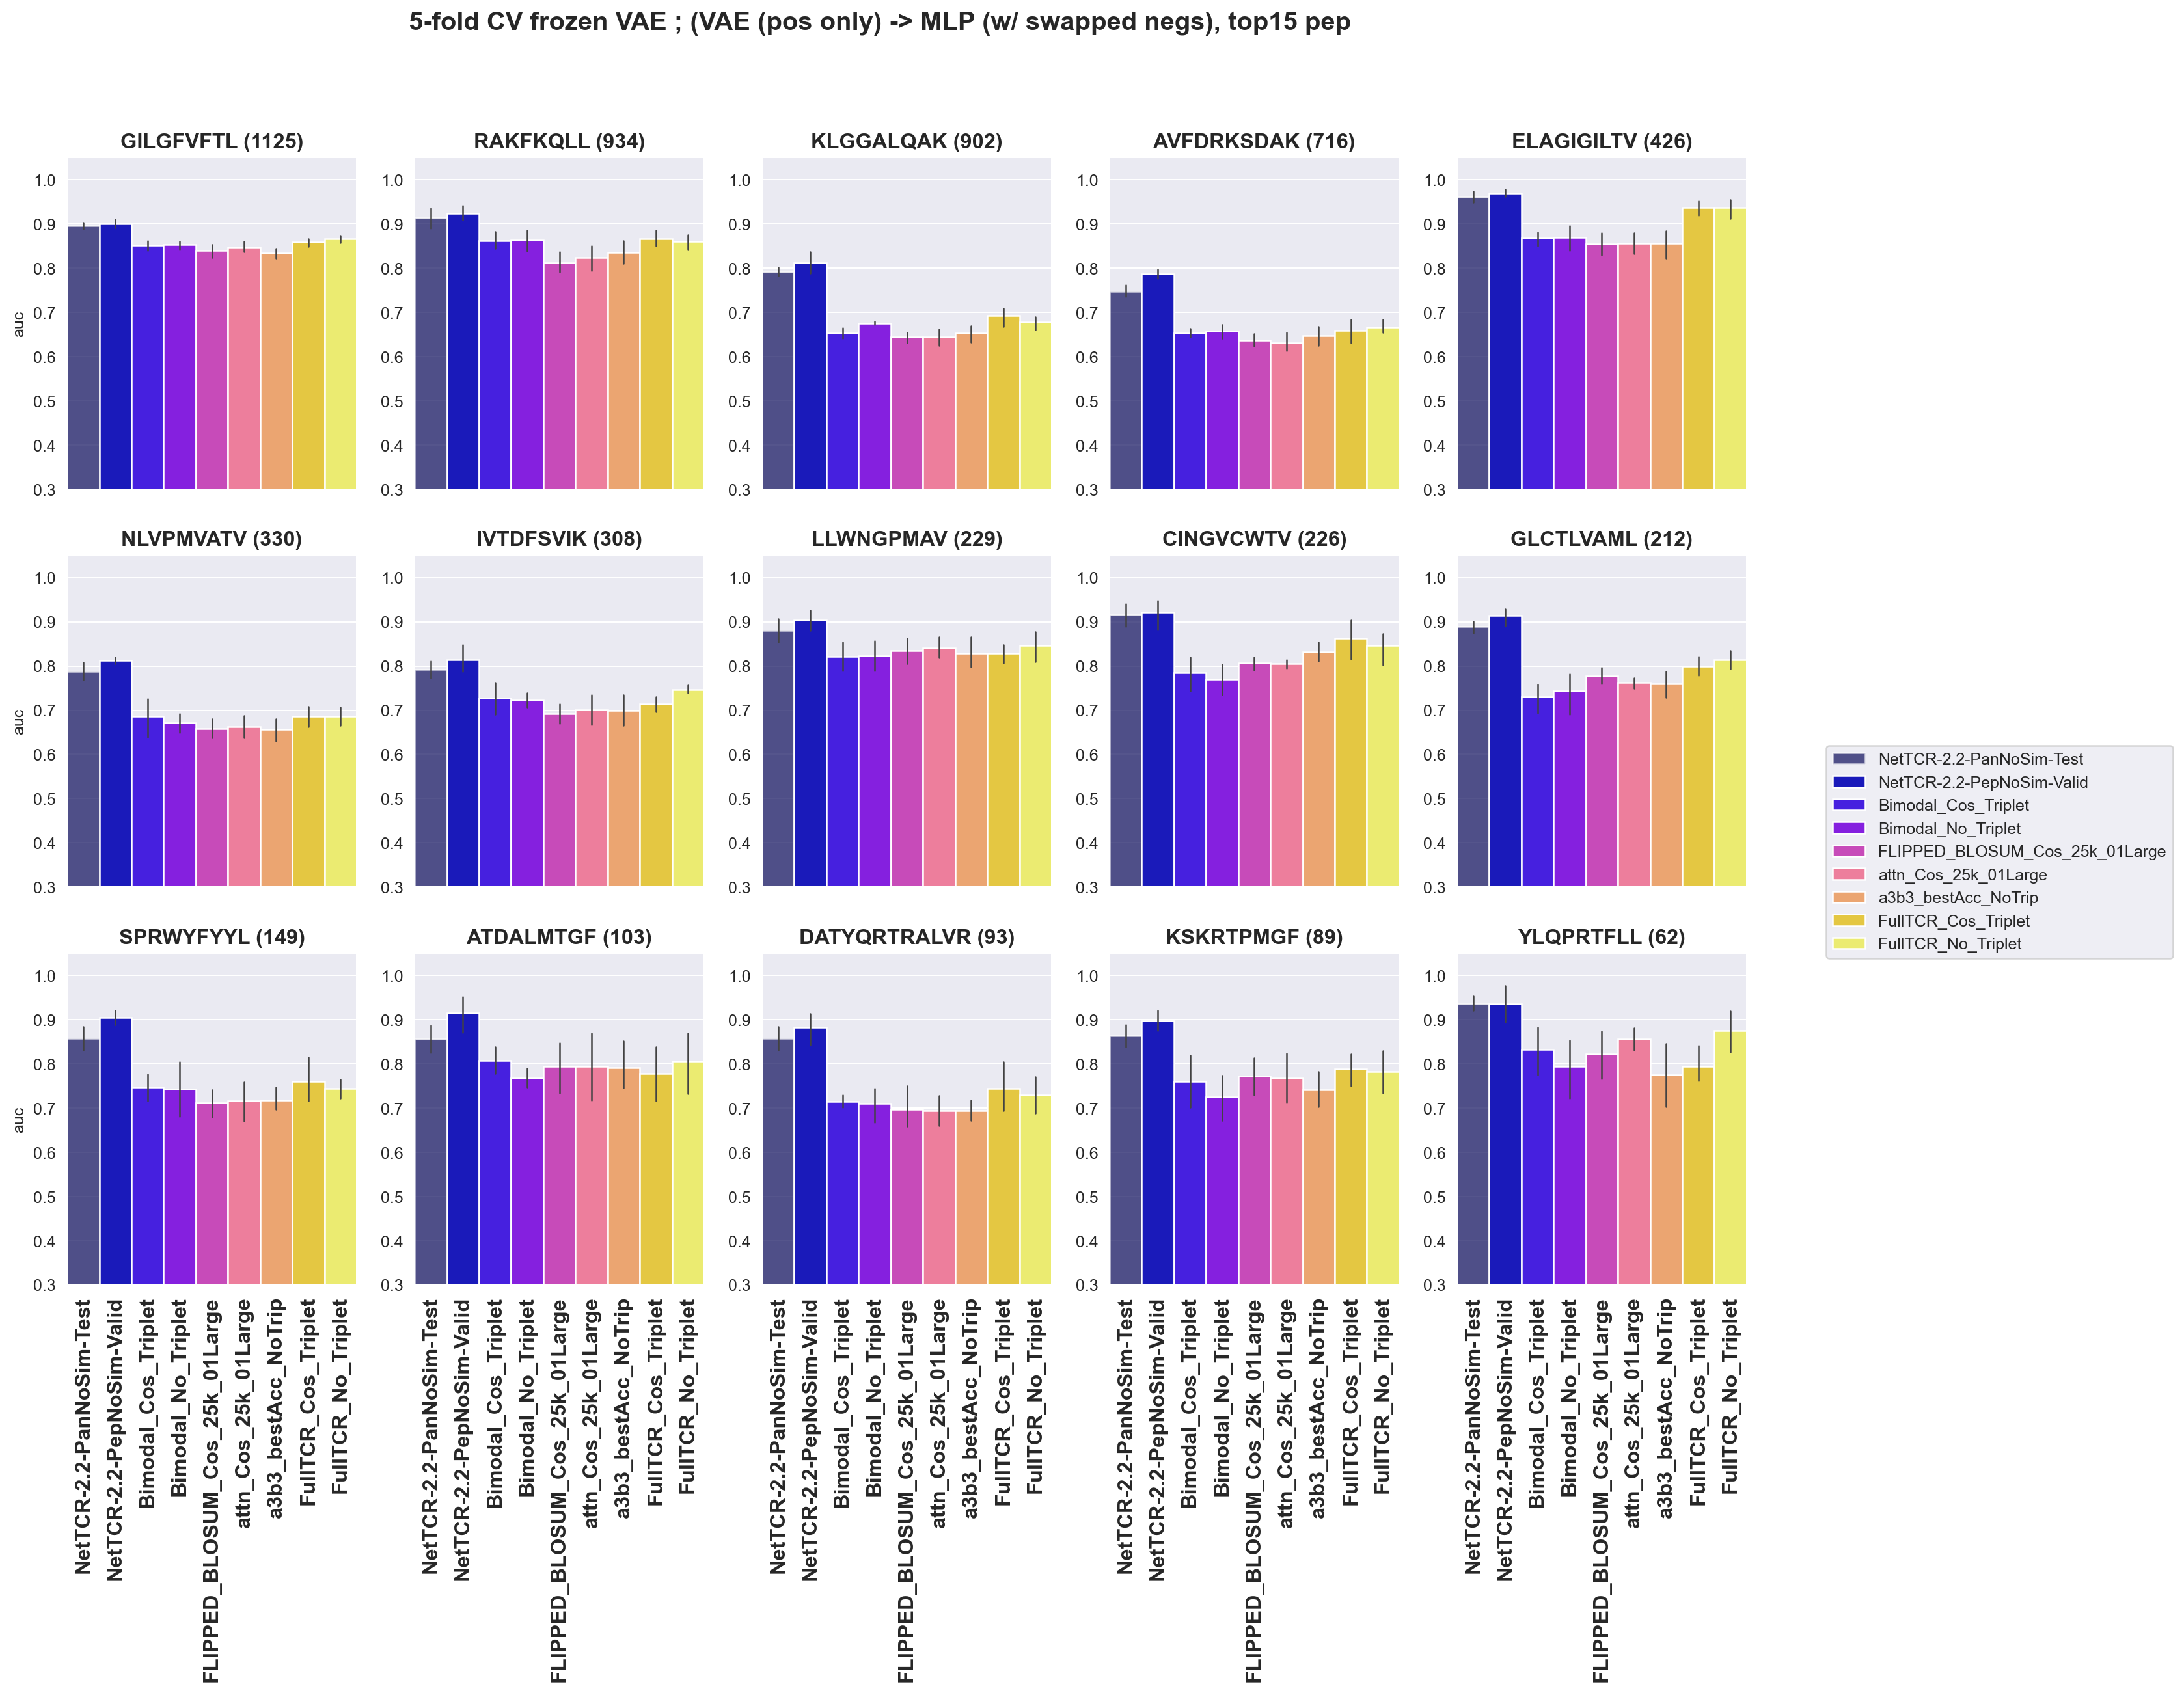

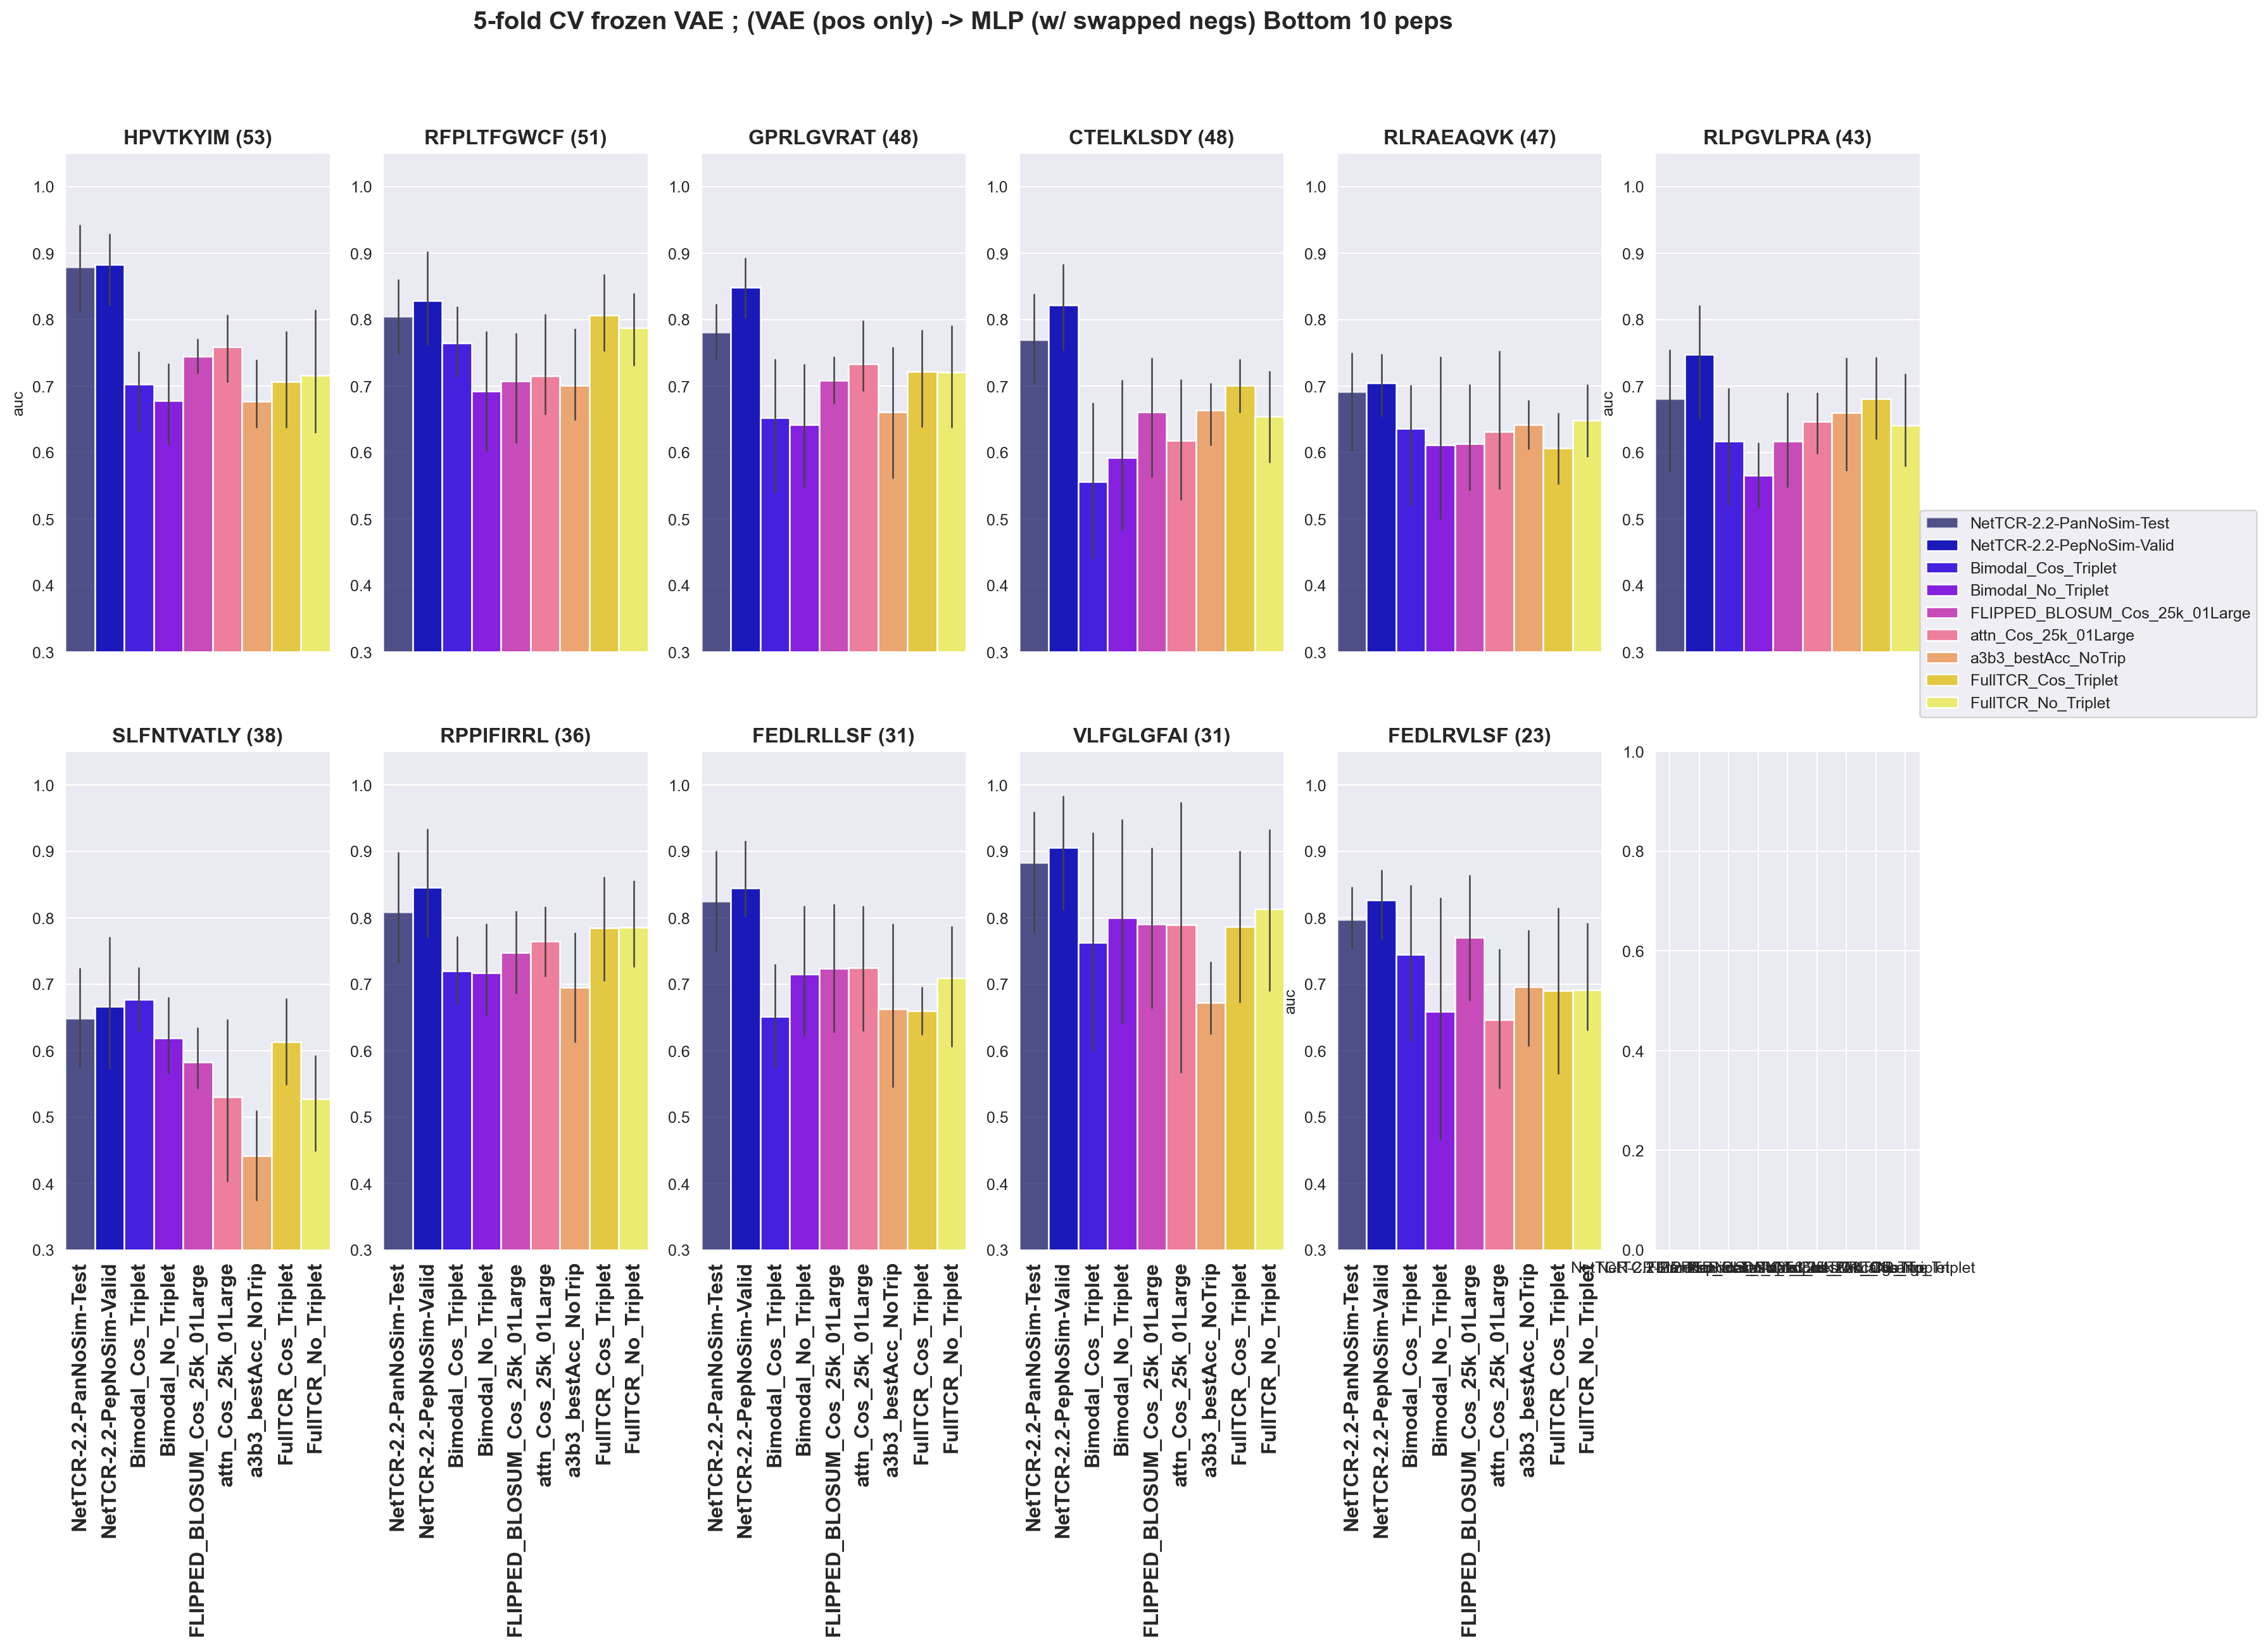

In [476]:
order=['NetTCR-2.2-PanNoSim-Test', 'NetTCR-2.2-PepNoSim-Valid',
        'Bimodal_Cos_Triplet', 'Bimodal_No_Triplet', 
        'FLIPPED_BLOSUM_Cos_25k_01Large',
        'attn_Cos_25k_01Large','a3b3_bestAcc_NoTrip', 
        'FullTCR_Cos_Triplet', 'FullTCR_No_Triplet']

f,a = plt.subplots(3, 5, figsize=(18.5,12.5), sharex=True)
a = a.ravel()

sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = merged3.reset_index().query('peptide==@pep')
    sns.barplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, width=1, errwidth=1, dodge=False,
                  order=order , hue_order=order)
    for bar in ax.containers[0]:
        bar.set_alpha(0.7)
    ax.set_ylim([0.3,1.05])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
    if i==14:
        ax.legend(bbox_to_anchor=(2.5, 1.65))
    else:
        ax.legend('', frameon=False)
        
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
# f.tight_layout(pad=1.05)


f,a = plt.subplots(2, 6, figsize=(21,12.5), sharex=True)
a = a.ravel()
sns.set_palette(get_palette('gnuplot2', len(order)))

for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = merged3.reset_index().query('peptide==@pep')
    sns.barplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, width=1, errwidth=1, dodge=False,
                  order=order , hue_order=order)
    for bar in ax.containers[0]:
        bar.set_alpha(0.7)
    ax.set_ylim([0.3,1.05])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
    if i==10:
        print('here')
        ax.legend(bbox_to_anchor=(3.5, 1.5))
    else:
        ax.legend('', frameon=False)
        
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

In [429]:
from src.utils import plot_vae_loss_accs, pkl_load

losses = glob.glob('../output/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_Mnre9/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_KFold_0_231215_1224_Mnre9/*loss*.pkl')
losses = [pkl_load(x) for x in losses]
losses = {**losses[0], **losses[1]}
metrics = glob.glob('../output/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_Mnre9/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_KFold_0_231215_1224_Mnre9/*metric*.pkl')
metrics = [pkl_load(x) for x in metrics]
metrics = {**metrics[0], **metrics[1]}
keys_to_remove = []

for k in metrics:
    if 'precision' in k or 'auc_01' in k or k == 'train_accuracy' or k == 'valid_accuracy':
        keys_to_remove.append(k)

for k in keys_to_remove:
    del metrics[k]

In [ ]:
flag, prism, ocean, gist_earth, terrain, gist_stern, gnuplot, gnuplot2, CMRmap,cubehelix,
brg, gist_rainbow, rainbow, jet, turbo, nipy_spectral and gist_ncar

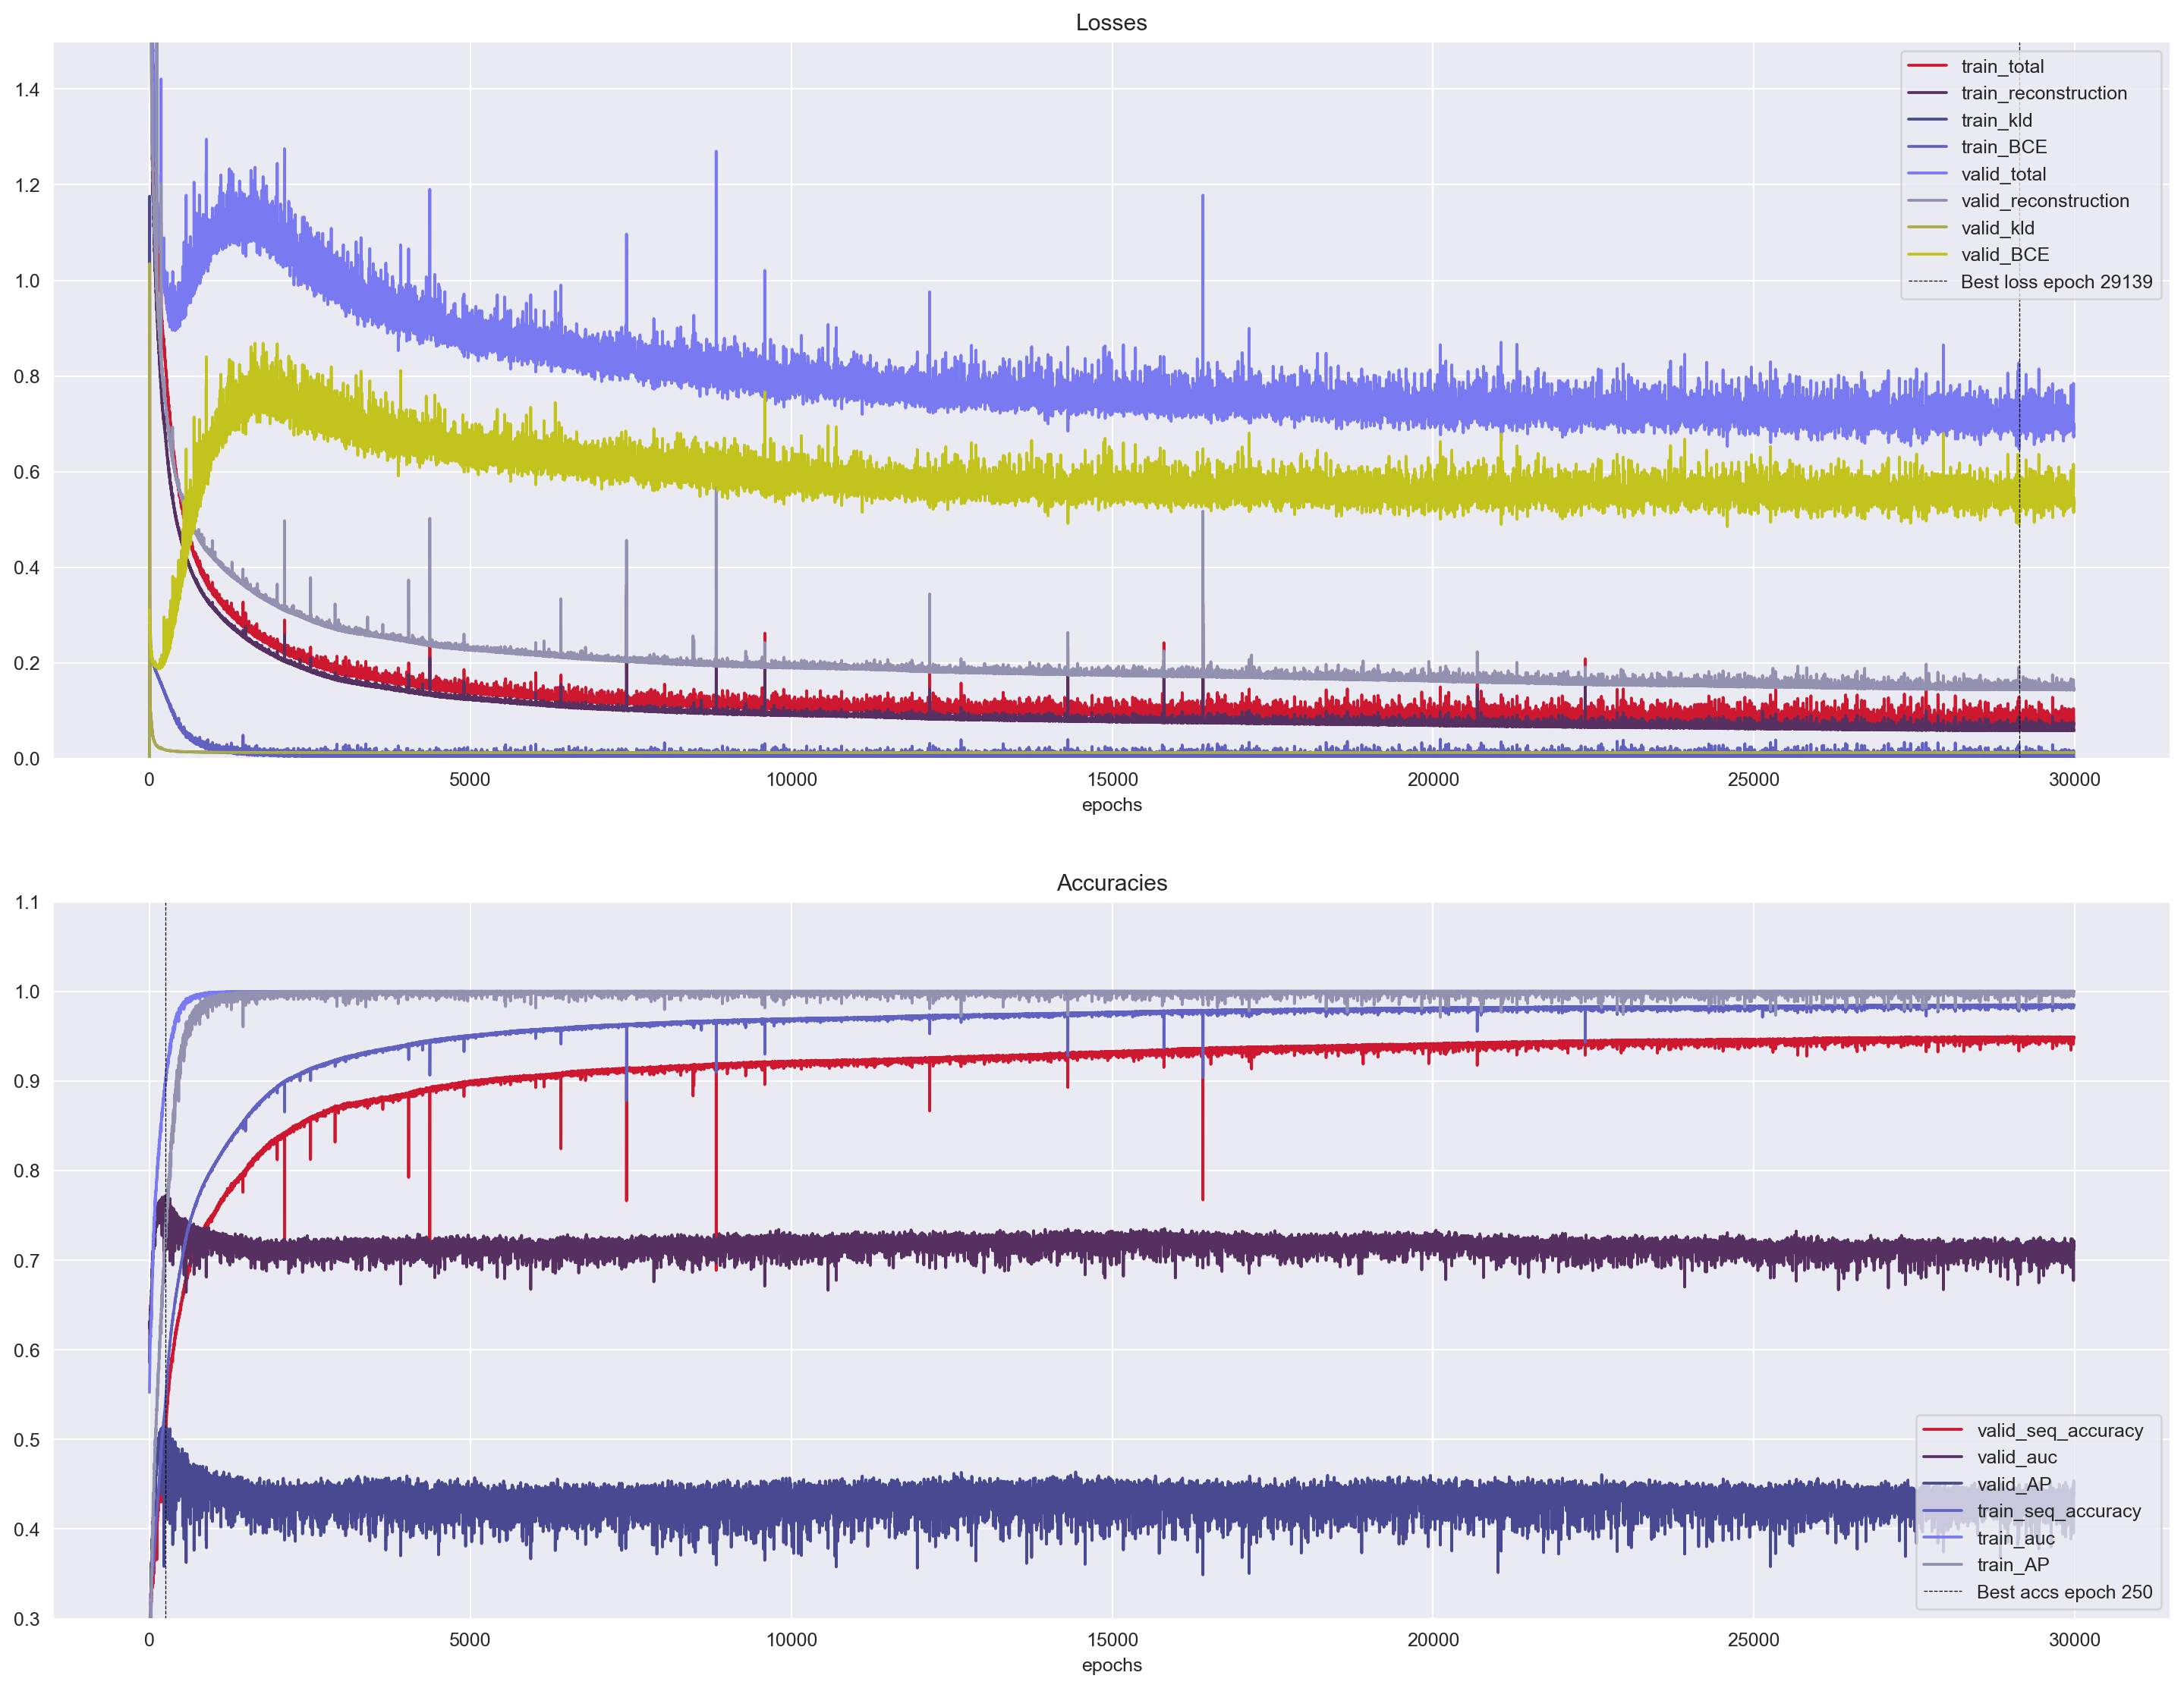

In [441]:
f,a = plot_vae_loss_accs(losses, metrics, '', './', palette='gist_earth',
                         ylim0=[0,1.5], ylim1=[0.3, 1.1], figsize=(20,15))

# Check clustering

In [29]:
def get_cluster_summary(input_df, cluster='', label='label', feature='TSNE_1', kf=True):
    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        return summary, df

def get_clustering_stats(summary_df, percent=50, size=3, dict=False, return_df=True):
    tmp = summary_df.query('purity_percent>@percent and cluster_size>=@size')
    results = {'n_clusters':len(tmp), 
               'n_total_tcrs':tmp.cluster_size.sum(), 
               'mean_cluster_size': tmp.cluster_size.mean(), 
               'n_singletons': len(summary_df.query('cluster_size==1')),
               'mean_purity': tmp.purity_percent.mean(),
               'max_purity': tmp.purity_percent.max(),
               'med_purity': tmp.purity_percent.median(),
               'std_purity': tmp.purity_percent.std(),
               'retention': tmp.cluster_size.sum() / summary_df.cluster_size.sum()} 
    if dict:
        return results
    elif return_df:
        return pd.DataFrame(results, index=[0])
    else:
        return list(results.values())
        
def get_dist_matrix(preds, fold, distances=None, dist_type='cos'):
    """
    if distances is not None then it's precomputed and don't have to recompute each time
    """
    preds = preds.copy(deep=True)
    if distances is None:
        z_cols = [x for x in preds.columns if x.startswith('z_')]
        z = torch.from_numpy(preds[z_cols].values)
        dist_fct = {'cos': compute_cosine_distance, 'l1' : torch.cdist, 'l2': torch.cdist}[dist_type]
        p=1 if dist_type=='l1' else 2
        distances = dist_fct(z, z, p=p)
        print('HERE')
    
    preds['model_fold'] = fold
    preds['set'] = preds.apply(lambda x: 'train' if x['fold']!=x['partition'] else 'valid', axis=1)
    dist_matrix = pd.DataFrame(distances, 
                               columns = [x['A3']+'-'+x['B3'] for _, x in preds.iterrows()],
                               index = [x['A3']+'-'+x['B3'] for _, x in preds.iterrows()])
    dist_matrix['set'] = preds['set'].values
    dist_matrix['label'] = preds['peptide'].values
    dist_matrix['binder'] = preds['binder'].values
    dist_matrix['origin'] = preds['origin'].values
    return dist_matrix

def get_dist_preds_summary(name, preds, distances, threshold, k, purity_percent, cluster_size, dist_type='cos'):
    preds = preds.query('model_fold==@k').copy(deep=True)
    dist = get_dist_matrix(preds, k, distances, dist_type)
    dist['partition'] = preds.partition.values
    dist['feature'] = preds.z_0.values
    clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=threshold)
    dropcols = labcols + [x for x in dist.columns if 'pred_' in x] + ['partition' , 'feature']
    pred_clusters = clustering.fit_predict(dist.drop(columns=dropcols).values)
    dist[f'pred_cl_{threshold:.4f}'] = pred_clusters
    preds[f'pred_cl_{threshold:.4f}'] = pred_clusters
    preds['fold'] = k
    summary, _ = get_cluster_summary(dist, f'pred_cl_{threshold:.4f}', 'label', 'feature', True)
    summary['model_type'] = name
    summary['dist_type'] = dist_type
    summary['threshold'] = threshold
    summary['fold'] = k

    preds['set'] = preds.apply(lambda x: 'train' if x['modl_efold']!=x['partition'] else 'valid', axis=1)
    summary['set'] = summary.apply(lambda x: 'train' if x['modl_efold']!=x['partition'] else 'valid', axis=1)
    
    stats = pd.concat([get_clustering_stats(summary.query('set=="valid"'), purity_percent, cluster_size, return_df=True).assign(fold=k, set='valid'),
                       get_clustering_stats(summary.query('set=="train"'), purity_percent, cluster_size, return_df=True).assign(fold=k, set='train')])
    # Here disable returning the preds for now
    # return preds, summary, stats
    return preds, summary, stats

def pipeline_all_folds(name, preds, distances, dist_threshold, purity_percent, cluster_size, dist_type='cos'):
    # Here, preds should be the concatenated preds. from all folds (train+valid), then each fold will be queried using the model_fold column
    out = [get_dist_preds_summary(name, preds, distances, dist_threshold, k, purity_percent, cluster_size, dist_type) for k in sorted(preds.partition.unique())]
    # Here disable returning the preds for now 
    # predicted = pd.concat([x[0] for x in out])
    summaries = pd.concat([x[1] for x in out]).assign(name=name, threshold=dist_threshold)
    stats = pd.concat([x[2] for x in out]).assign(name=name, threshold=dist_threshold)
    return None, summaries, stats

In [46]:
from src.metrics import compute_cosine_distance
# 6 VAE models : 
# A Bimodal CosTrp (v51Sn) -> 49.98% mean seq acc (very low seq acc but good AUC, early epochs)
preds_a = pd.concat([pd.read_csv(x) for x in glob.glob('../output/231211_Bimodal_VAE_CLF_FirstRun_v51Sn/*/*valid*.csv')]).drop_duplicates(subset=['A1', 'A2', 'A3','B1','B2','B3'])
z_a = torch.from_numpy(preds_a[[x for x in preds_a.columns if x.startswith('z_')]].values)
cdist_a = compute_cosine_distance(z_a)

# B Bimodal NoTrp (Mnre9) -> 47.29% mean seq acc (very low seq acc but good AUC, early epochs)
preds_b = pd.concat([pd.read_csv(x) for x in glob.glob('../output/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_Mnre9/*/*valid*.csv')]).drop_duplicates(subset=['A1', 'A2', 'A3','B1','B2','B3'])
z_b = torch.from_numpy(preds_b[[x for x in preds_b.columns if x.startswith('z_')]].values)
cdist_b = compute_cosine_distance(z_b)

# C A3B3-CosTrp 25K 0.1 large model (7VzZ5) -> 91.67% mean seq acc
preds_c = pd.concat([pd.read_csv(x) for x in glob.glob('../output/TripletTest/231108_TripletCosine_A3B3_margin_01_25k_epochs_larger_model_7VzZ5/*/*valid*.csv')]).drop_duplicates(subset=['A1', 'A2', 'A3','B1','B2','B3'])
z_c = torch.from_numpy(preds_c[[x for x in preds_c.columns if x.startswith('z_')]].values)
cdist_c = compute_cosine_distance(z_c)

# D A3B3-NoTrp ~97% seq accuracy (PERFx) -> 97.96% mean seq acc
preds_d = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2312XX_MaxAccuracy/A3B3_NoTriplet_KLD1e-4_wd1e-6_nl128_PERFx/*/*valid*.csv')]).drop_duplicates(subset=['A1', 'A2', 'A3','B1','B2','B3'])
z_d = torch.from_numpy(preds_d[[x for x in preds_d.columns if x.startswith('z_')]].values)
cdist_d = compute_cosine_distance(z_d)

# E FullTCR Cos Trp (7GsCQ) -> 97.5% mean seq acc
preds_e = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2312XX_MaxAccuracy/AllChains_TripletCos_7GsCQ/*/*valid*.csv')]).drop_duplicates(subset=['A1', 'A2', 'A3','B1','B2','B3'])
z_e = torch.from_numpy(preds_e[[x for x in preds_e.columns if x.startswith('z_')]].values)
cdist_e = compute_cosine_distance(z_e)

# F FullTCR No Trp (PCuSO) -> 97.93% mean seq acc
preds_f = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2312XX_MaxAccuracy/AllChains_97pAcc_NoTriplet_PCuSO/*/*valid*.csv')]).drop_duplicates(subset=['A1', 'A2', 'A3','B1','B2','B3'])
z_f = torch.from_numpy(preds_f[[x for x in preds_f.columns if x.startswith('z_')]].values)
cdist_f = compute_cosine_distance(z_f)


In [56]:
# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from src.train_eval import predict_bimodal, predict_model
def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model, kwargs = load_model_full(pt, js, return_json=True)
    return model, kwargs

In [77]:
from torch.utils.data import SequentialSampler

pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
dataset_bimodal = BimodalTCRpMHCDataset(mix_df, 0, 0, 22, 0, 0, 23, encoding='BL50LO', pad_scale=-20, pep_encoding='BL50LO', pep_pad_scale=-20)
dataset_a3b3 = FullTCRDataset(pos_df, 0, 0, 22, 0, 0, 23, encoding='BL50LO', pad_scale=-20)
dataset_full = FullTCRDataset(pos_df, 7, 8, 22, 6, 7, 23, encoding='BL50LO', pad_scale=-20)
loader_bimodal = dataset_bimodal.get_dataloader(1024, SequentialSampler)
loader_a3b3 = dataset_a3b3.get_dataloader(1024, SequentialSampler)
loader_full = dataset_full.get_dataloader(1024, SequentialSampler)

In [ ]:
preds = {}
dists = {}
for k, name, dirs, (dataset,loader) in zip(['a','b','c','d','e','f'],
                                           ['Bimodal_CosTrp', 'Bimodal_NoTrp',
                                       'A3B3_CosTrp', 'A3B3_NoTrp',
                                       'FullTCR_CosTrp', 'FullTCR_NoTrp'],
                   ['../output/231211_Bimodal_VAE_CLF_FirstRun_v51Sn/',
                    '../output/231211_Bimodal_VAE_CLF_2ndRun_NoTriplet_Mnre9/',
                    '../output/TripletTest/231108_TripletCosine_A3B3_margin_01_25k_epochs_larger_model_7VzZ5/',
                    '../output/2312XX_MaxAccuracy/A3B3_NoTriplet_KLD1e-4_wd1e-6_nl128_PERFx/',
                    '../output/2312XX_MaxAccuracy/AllChains_TripletCos_7GsCQ/',
                    '../output/2312XX_MaxAccuracy/AllChains_97pAcc_NoTriplet_PCuSO/'],
                    [(dataset_bimodal, loader_bimodal),
                     (dataset_bimodal, loader_bimodal),
                     (dataset_a3b3, loader_a3b3),
                     (dataset_a3b3, loader_a3b3),
                     (dataset_full, loader_full),
                     (dataset_full, loader_full)]):
    print('xd')
    preds[k] = {}
    dists[k] = {}
    pf = predict_bimodal if 'Bimodal' in name else predict_model
    fdirs=sorted(glob.glob(f'{dirs}/*/'))
    
    for i, fd in enumerate(fdirs):
        print(fd)
        model, kwargs = get_model(fd)
        predictions = pf(model, dataset, loader).query('binder==1')
        predictions['model_fold']=i
        predictions['set'] = predictions.apply(lambda x: 'train' if x['model_fold']!=x['partition'] else 'valid', axis=1)
        z = torch.from_numpy(predictions[[x for x in predictions.columns if x.startswith('z_')]].values)
        distances = compute_cosine_distance(z)
        dists[k][i] = distances
        preds[k][i] = predictions
        
        dist_matrix = pd.DataFrame(distances, 
                               columns = [x['A3']+'-'+x['B3'] for _, x in predictions.iterrows()],
                               index = [x['A3']+'-'+x['B3'] for _, x in predictions.iterrows()])
        dist_matrix['model_fold'] = predictions['model_fold'].values
        dist_matrix['partition'] = predictions['partition'].values
        dist_matrix['set'] = predictions['set'].values
        dist_matrix['label'] = predictions['peptide'].values
        dist_matrix['binder'] = predictions['binder'].values
        dist_matrix['origin'] = predictions['origin'].values
        dist_matrix.to_csv(f'../output/231222_ClusteringComparisons/dists/dists_{k}_{name}_fold_{i}.csv')
        predictions.to_csv(f'../output/231222_ClusteringComparisons/preds/preds_{k}_{name}_fold_{i}.csv', index=False)
        

xd
../output/231211_Bimodal_VAE_CLF_FirstRun_v51Sn/231211_Bimodal_VAE_CLF_FirstRun_KFold_0_231213_1429_v51Sn/
Reloading best model:
Best epoch: 195
total: 0.7038586619610409
reconstruction: 0.5383442621123095
kld: 0.014297966628505993
triplet: 0.023775446642727478
BCE: 0.12744099609706752
seq_accuracy: 0.47668400406837463
auc: 0.76935
auc_01: 0.64279
auc_01_real: 0.3213
precision: 0.71888
accuracy: 0.8583
AP: 0.50461
MLP metrics: auc: 0.851	auc_01: 0.704	auc_01_real: 0.438	precision: 0.831	accuracy: 0.874	AP: 0.632


-  A)  Bimodal CosTrp (v51Sn) -> 49.98% mean seq acc (very low seq acc but good AUC, early epochs)- 
-  B)  Bimodal NoTrp (Mnre9) -> 47.29% mean seq acc (very low seq acc but good AUC, early epochs)- 
-  C)  A3B3-CosTrp 25K 0.1 large model (7VzZ5) -> 91.67% mean seq acc- 
-  D)  A3B3-NoTrp ~97% seq accuracy (PERFx) -> 97.96% mean seq acc- 
-  E)  FullTCR Cos Trp (7GsCQ) -> 97.5% mean seq acc- 
-  F)  FullTCR No Trp (PCuSO) -> 97.93% mean seq acc


In [583]:
from sklearn.cluster import AgglomerativeClustering, KMeans
labcols = ['set', 'label', 'binder', 'origin']

summaries = []
stats = []
for dist_threshold in tqdm(np.linspace(0.185, 1.25, 50).round(3), desc='ntr'):
    cos_ag = AgglomerativeClustering(n_clusters=None, metric='precomputed', 
                                 linkage = 'complete', distance_threshold=t)
    for name, preds, distances in zip(['Bimodal_CosTrp_49.98', 'Bimodal_NoTrp_47.29',
                                       'A3B3_CosTrp_91.67', 'A3B3_NoTrp_97.96',
                                       'FullTCR_CosTrp_97.5', 'FullTCR_NoTrp_97.93'],
                                       [preds_a, preds_b, preds_c, preds_d, preds_e, preds_f],
                                       [cdist_a, cdist_b, cdist_c, cdist_d, cdist_e, cdist_f]):
        _, summary, stat = pipeline_all_folds(name, preds, distances, dist_threshold, purity_percent=66.6, cluster_size=5)
        summaries.append(summary)
        stats.append(stat)


ntr: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [39:43<00:00, 47.67s/it]


In [584]:
summaries = pd.concat(summaries)
summaries.to_csv('../output/231222_new_summaries.csv')

In [585]:
stats = pd.concat(stats)
stats.to_csv('../output/231222_new_stats.csv')

In [607]:
stats.query('name.str.contains("Bimodal")').groupby(['name', 'set','threshold']).agg(mean_purity=('mean_purity', 'mean'),
                                               mean_retention=('retention', 'mean'),
                                               med_purity=('med_purity','median'),
                                               max_purity=('max_purity','max'),
                                               n_singletons=('n_singletons','sum')).sort_values('mean_retention',ascending=False).head(10)

mean_purity  mean_retention  med_purity  \
name                 set   threshold                                            
Bimodal_CosTrp_49.98 train 0.185        70.720755        0.011176   66.666667   
                     valid 0.185        70.793651        0.011175   66.666667   
                           0.207        68.630952        0.007557   66.666667   
                     train 0.207        68.978458        0.007556   66.666667   
Bimodal_NoTrp_47.29  train 0.185        68.888889        0.006139   66.666667   
                     valid 0.185        69.345238        0.006134   67.857143   
Bimodal_CosTrp_49.98 valid 0.228        73.174603        0.005509   69.047619   
                     train 0.228        74.907937        0.005509   69.047619   
                     valid 0.272        77.195767        0.004565   80.000000   
                     train 0.272        79.590476        0.004565   80.000000   

                                      max_purity  n_singletons  
name                 set   threshold                            
Bimodal_CosTrp_49.98 train 0.185       83.333333            60  
                     valid 0.185       83.333333            15  
                           0.207       80.000000             9  
                     train 0.207       80.000000            36  
Bimodal_NoTrp_47.29  train 0.185       75.000000            40  
                     valid 0.185       75.000000            10  
Bimodal_CosTrp_49.98 valid 0.228      100.000000             4  
                     train 0.228      100.000000            16  
                     valid 0.272      100.000000             1  
                     train 0.272      100.000000             4

In [602]:
stats.groupby(['name', 'set','threshold']).agg(mean_purity=('mean_purity', 'mean'),
                                               mean_retention=('retention', 'mean'),
                                               med_purity=('med_purity','median'),
                                               min_purity=('mean_purity','min'),
                                               n_singletons=('n_singletons','sum')).sort_values('mean_retention',ascending=False).head(10)

mean_purity  mean_retention  med_purity  \
name                set   threshold                                            
FullTCR_CosTrp_97.5 valid 0.272        83.479705        0.211718   83.333333   
                    train 0.272        83.119520        0.211711   83.333333   
                    valid 0.294        81.946096        0.204001   83.974359   
                    train 0.294        81.767113        0.203998   81.818182   
                    valid 0.250        85.040201        0.198975   84.523810   
                    train 0.250        84.759544        0.198962   85.714286   
                          0.315        79.957948        0.193609   77.777778   
                    valid 0.315        79.885452        0.193605   78.472222   
                          0.228        86.408197        0.175981   87.301587   
                    train 0.228        86.403923        0.175980   87.500000   

                                     min_purity  n_singletons  
name                set   threshold                            
FullTCR_CosTrp_97.5 valid 0.272       81.549164            12  
                    train 0.272       82.202021            48  
                    valid 0.294       79.487146             6  
                    train 0.294       80.765868            24  
                    valid 0.250       83.401122            46  
                    train 0.250       84.110529           184  
                          0.315       79.558010             8  
                    valid 0.315       77.836246             2  
                          0.228       83.732831           146  
                    train 0.228       86.199580           584

In [624]:
out_e_0272 = [get_dist_preds_summary('FullTCR_CosTrp_97.5', preds_e, cdist_e, 0.272, 
                                     k, 66.6, 5, 'cos') for k in sorted(preds_e.partition.unique())]
preds_e_0272, summ_e_0272, stat_e_0272 = pd.concat([x[0] for x in out_e_0272]), pd.concat([x[1] for x in out_e_0272]), pd.concat([x[2] for x in out_e_0272])

out_a_0185 = [get_dist_preds_summary('Bimodal_CosTrp_49.9', preds_a, cdist_a, 0.185, 
                                     k, 66.6, 5, 'cos') for k in sorted(preds_a.partition.unique())]
preds_a_0185, summ_a_0185, stat_a_0185 = pd.concat([x[0] for x in out_a_0185]), pd.concat([x[1] for x in out_a_0185]), pd.concat([x[2] for x in out_a_0185])

In [634]:
stat_e_0272

n_clusters  n_total_tcrs  mean_cluster_size  n_singletons  mean_purity  \
0          20           220          11.000000             5    88.303800   
0         116          1125           9.698276             7    82.202021   
0          32           293           9.156250             2    81.812996   
0         104          1052          10.115385            10    83.495140   
0          32           340          10.625000             1    81.549164   
0         104          1005           9.663462            11    83.576319   
0          20           189           9.450000             3    82.966390   
0         116          1156           9.965517             9    83.122264   
0          32           303           9.468750             1    82.766173   
0         104          1042          10.019231            11    83.201855   

   max_purity  med_purity  std_purity  retention  fold    set  
0       100.0   89.444444   10.665598   0.172684     0  valid  
0       100.0   83.333333   11.295625   0.221500     0  train  
0       100.0   80.000000   12.787496   0.230527     1  valid  
0       100.0   83.333333   10.941633   0.207005     1  train  
0       100.0   83.333333    9.914904   0.267296     2  valid  
0       100.0   83.333333   11.791651   0.197796     2  train  
0       100.0   80.909091   11.709225   0.148936     3  valid  
0       100.0   83.333333   11.368923   0.227380     3  train  
0       100.0   83.333333   11.232198   0.239148     4  valid  
0       100.0   83.333333   11.471273   0.204876     4  train

TSNE


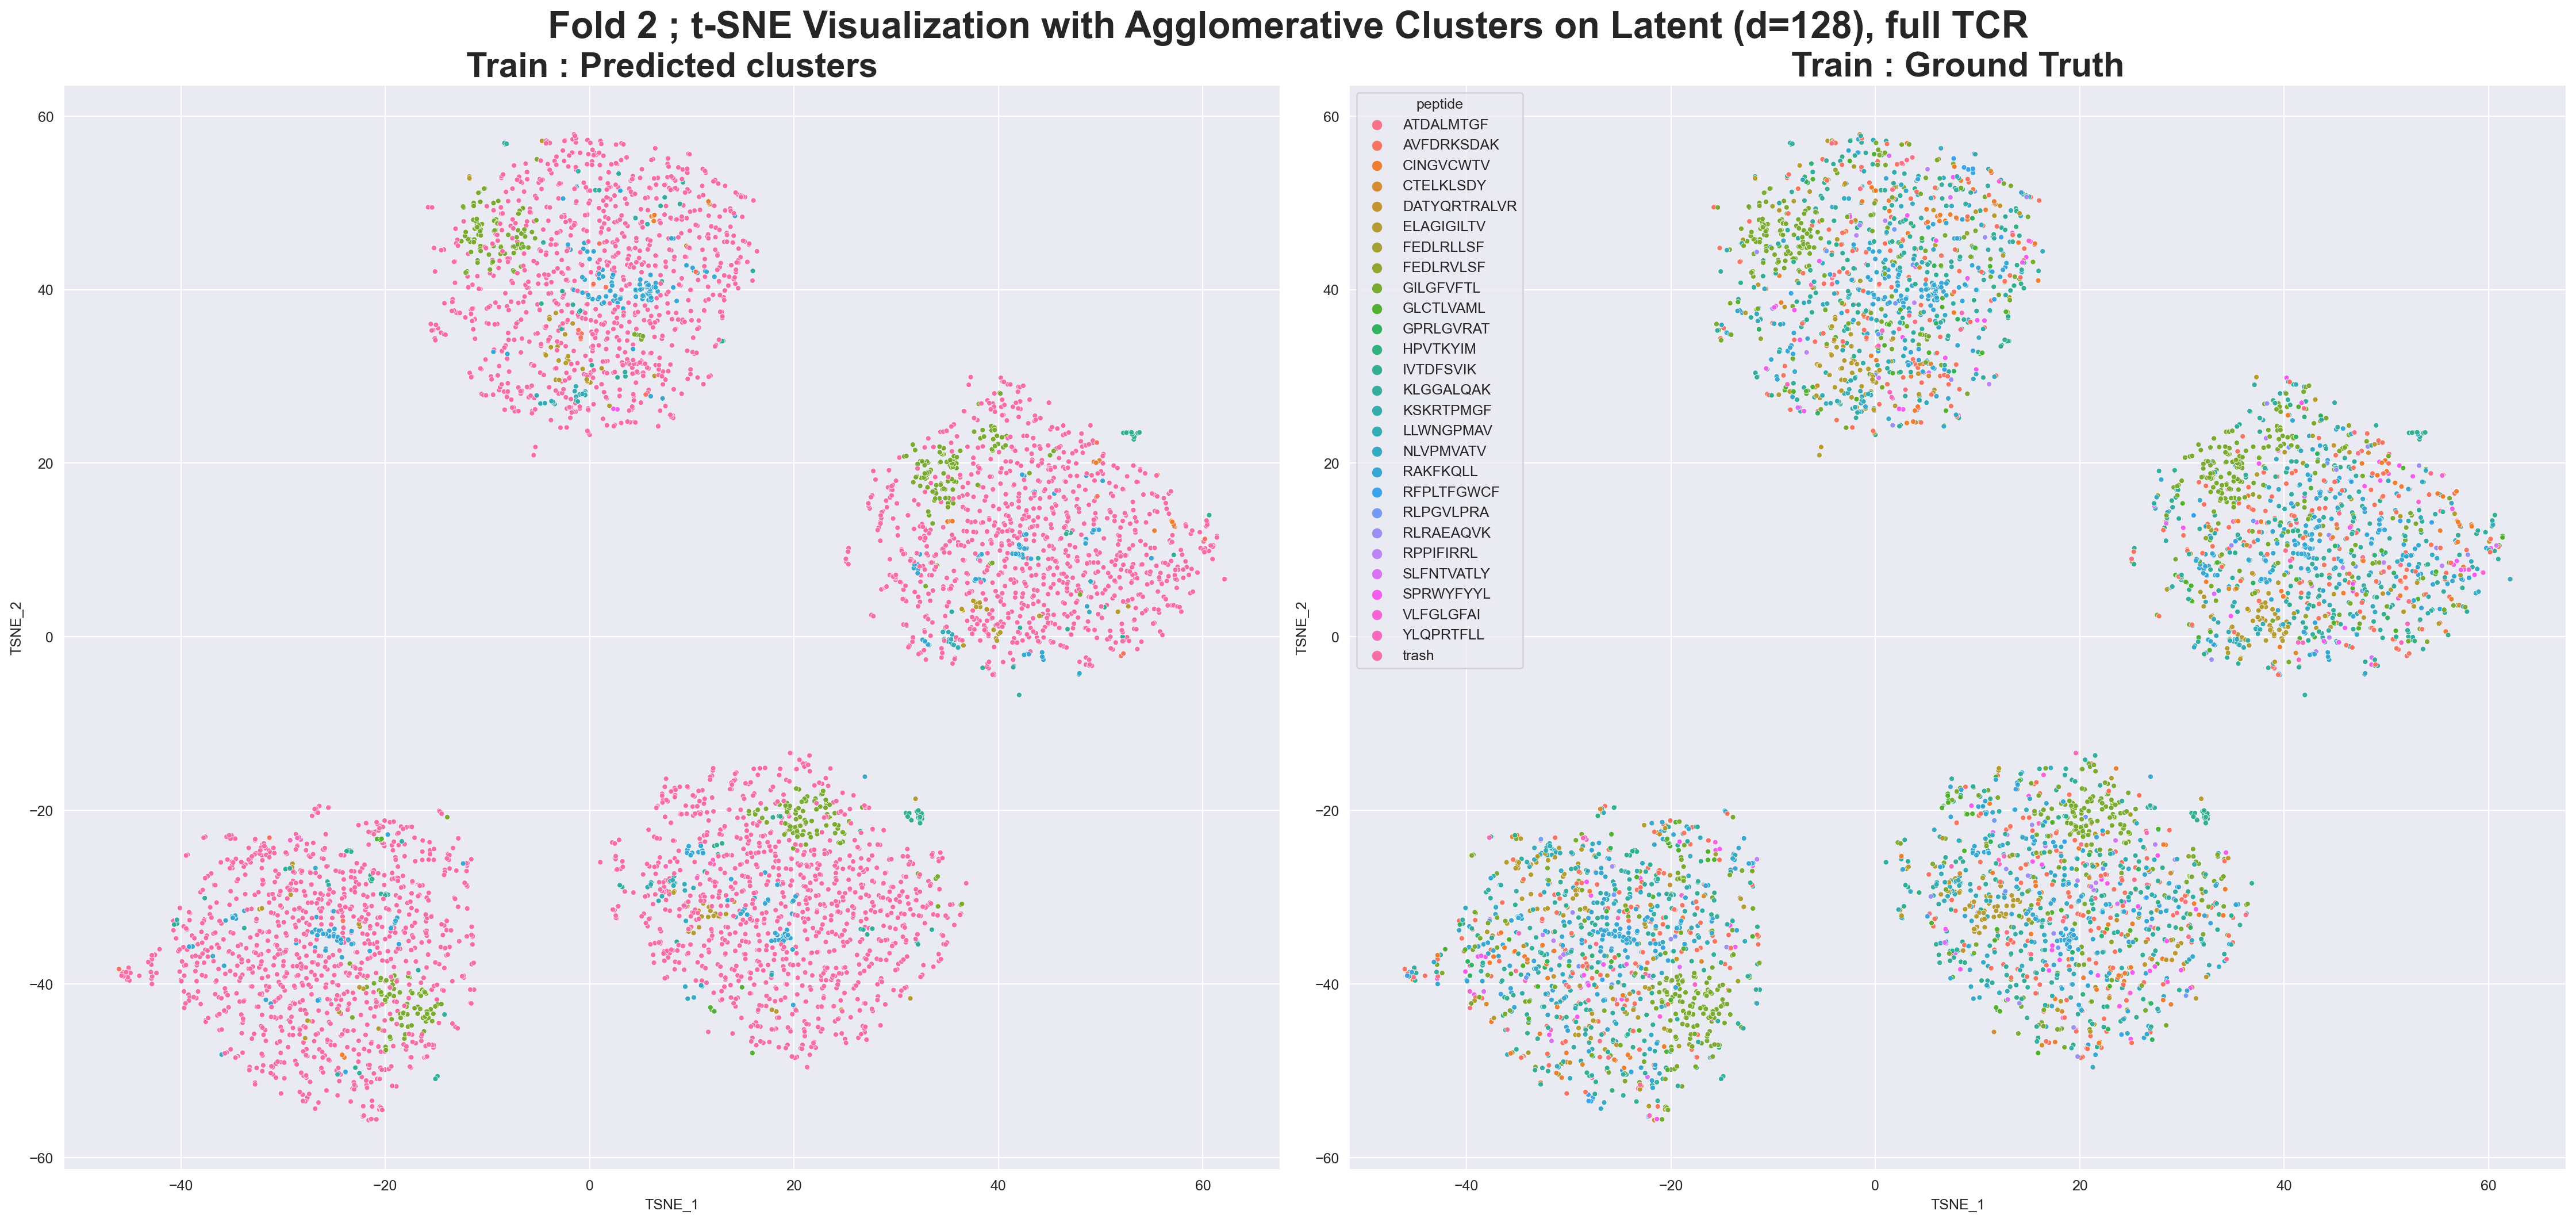

In [651]:
from sklearn.manifold import TSNE
from umap import UMAP
import colorcet as cc
from src.utils import get_palette

df_e0272 = pd.merge(preds_e_0272, summ_e_0272[['pred_cl_0.2720', 'label', 'purity_percent', 'cluster_size', 'fold']], 
         left_on=['pred_cl_0.2720', 'fold'], right_on=['pred_cl_0.2720', 'fold'])

f2 = df_e0272.query('fold==2')
f2.reset_index(drop=True)

train = f2.query('fold==2 and set=="train"')
valid = f2.query('fold==2 and set=="valid"')
latent_dim = 128
z_train = train[[f'z_{i}' for i in range(latent_dim)]].values
labels_train = train['peptide'].values
z_valid = valid[[f'z_{i}' for i in range(latent_dim)]].values
labels_valid = valid['peptide'].values


palette = sns.color_palette(cc.glasbey, n_colors=26)
sns.set_palette(palette)

print('TSNE')
tsne = TSNE(n_components=2, metric='euclidean', perplexity=50)

latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]

train[['TSNE_1', 'TSNE_2']] = tsne_train
train['pred_label'] = train.apply(lambda x: x['label'] if x['purity_percent']>=66.67 else 'trash', axis=1)

valid[['TSNE_1', 'TSNE_2']] = tsne_valid
valid['pred_label'] = valid.apply(lambda x: x['label'] if x['purity_percent']>=66.67 else 'trash', axis=1)

f,a = plt.subplots(1,2, figsize=(25,12))
a = a.ravel()

fold=2
pep_order = sorted(f2.peptide.unique()) + ['trash']

sns.scatterplot(data=train, 
                x='TSNE_1', y='TSNE_2',  s=13, hue='pred_label', hue_order=pep_order, ax = a[0])
sns.scatterplot(data=train, 
                x='TSNE_1', y='TSNE_2',  s=13, hue='peptide', hue_order=pep_order, ax = a[1])

a[0].set_title('Train : Predicted clusters', fontsize=24, fontweight='semibold')
a[1].set_title('Train : Ground Truth', fontsize=24, fontweight='semibold')
a[0].legend('', frameon=False)

f.suptitle(f'Fold {fold} ; t-SNE Visualization with Agglomerative Clusters on Latent (d=128), full TCR', fontsize=26, fontweight='semibold')
f.tight_layout()
f.savefig(f'../output/train_preds_fold2_FullTCR_CosTrp_7GsCQ.png', bbox_inches='tight', dpi=200)